In [31]:
import json, requests, csv, time, operator
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import ast
import seaborn as sns
import time
import datetime
from sklearn.gaussian_process import GaussianProcess
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import Bio.Statistics.lowess as lw
import warnings; warnings.simplefilter('ignore')
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Split the output file into csv with columns(unused)

In [ ]:
with open('output_file.csv', 'r',encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    next(csv_reader)
    
    file_to_write = open('split_file.csv', 'w',encoding="utf8", newline='')
    csv_writer = csv.writer(file_to_write,delimiter=';')
    headers=['id','imdb_id','title','original_language','adult','collection','runtime',
            'popularity','vote_average','vote_count','release_date','budget','revenue',
            'release_dates','genres','production_companies','production_countries','cast','crew','keywords']
    csv_writer.writerow(headers)
    
    for row in csv_reader:
        row_to_write=[]
        json_data=json.loads(row[1])
        if('status_code' in json_data):
            continue
        row_to_write.append(json_data['id'])
        row_to_write.append(json_data['imdb_id'])
        row_to_write.append(json_data['title'])
        row_to_write.append(json_data['original_language'])
        row_to_write.append(json_data['adult'])
        
        if json_data['belongs_to_collection'] is not None:
            row_to_write.append(json_data['belongs_to_collection']['id'])
        else:
            row_to_write.append(None)
            
        row_to_write.append(json_data['runtime'])
        row_to_write.append(json_data['popularity'])
        row_to_write.append(json_data['vote_average'])
        row_to_write.append(json_data['vote_count'])
        row_to_write.append(json_data['release_date'])
        row_to_write.append(json_data['budget'])
        row_to_write.append(json_data['revenue'])
        
        if 'release_dates' in json_data:
            release_dates=json_data['release_dates']['results']
            for release_language in release_dates:
                for single_release in release_language['release_dates']:
                    del single_release['certification']
                    del single_release['iso_639_1']
                    if 'note' in single_release:
                        del single_release['note']
            row_to_write.append(release_dates)
        
        genres=json_data['genres']
       # for genre in genres:
       #     del genre['name']
        row_to_write.append(genres)
            
        companies=json_data['production_companies']
        #for company in companies:
        #    del company['name']
        row_to_write.append(companies)
        
        countries=json_data['production_countries']
        #for country in countries:
        #    del country['name']
        row_to_write.append(countries)
        
        cast=json_data['credits']['cast']
        for actor in cast:
            del actor['cast_id']
            del actor['character']
            del actor['credit_id']
          #  del actor['name']
            del actor['order']
            del actor['profile_path']
        row_to_write.append(cast)
        
        crew=json_data['credits']['crew']
        for crewman in crew:
            del crewman['credit_id']
          #  del crewman['name']
            del crewman['profile_path']
        row_to_write.append(crew)
        
        row_to_write.append(json_data['keywords']['keywords'])
        
        csv_writer.writerow(row_to_write)
   
    file_to_write.close()

# Read data into dataframe

In [3]:
test_data = pd.read_csv('full_data.csv',delimiter=',')
test_data = test_data.drop("Unnamed: 0", 1)
test_data = test_data.drop(['vote_count', 'vote_average'], axis=1)
test_data = test_data.drop(['metacritic'], axis=1)

# Remove NaN and 0 rating count

In [4]:
test_data['rating_count'] = test_data['rating_count'].replace(0,np.nan)
test_data = test_data[np.isfinite(test_data['rating_count'])]
test_data['cast'] = test_data['cast'].replace('[]',np.nan)
test_data['crew'] = test_data['crew'].replace('[]',np.nan)
test_data = test_data[pd.notnull(test_data['cast'])]
test_data = test_data[pd.notnull(test_data['crew'])]

# Scatterplot by genres

In [5]:
x_genre=[]
y_score=[]

for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    for genre in row_genres:
        x_genre.append(genre['name'])
        y_score.append(row['rating'])      

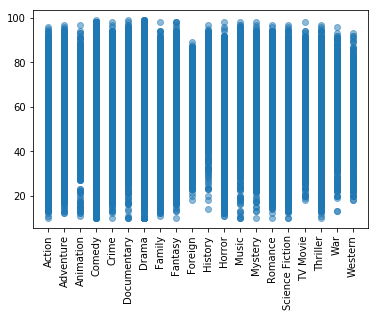

In [6]:
plt.scatter(x_genre, y_score, alpha=0.5)
plt.xticks(rotation=90)
plt.show()

# Violinplot by genres

In [8]:
genres_dict={}
for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    for genre in row_genres:
        if genre['name'] not in genres_dict:
            genres_dict[genre['name']]=[]
        genres_dict[genre['name']].append(row['rating'])

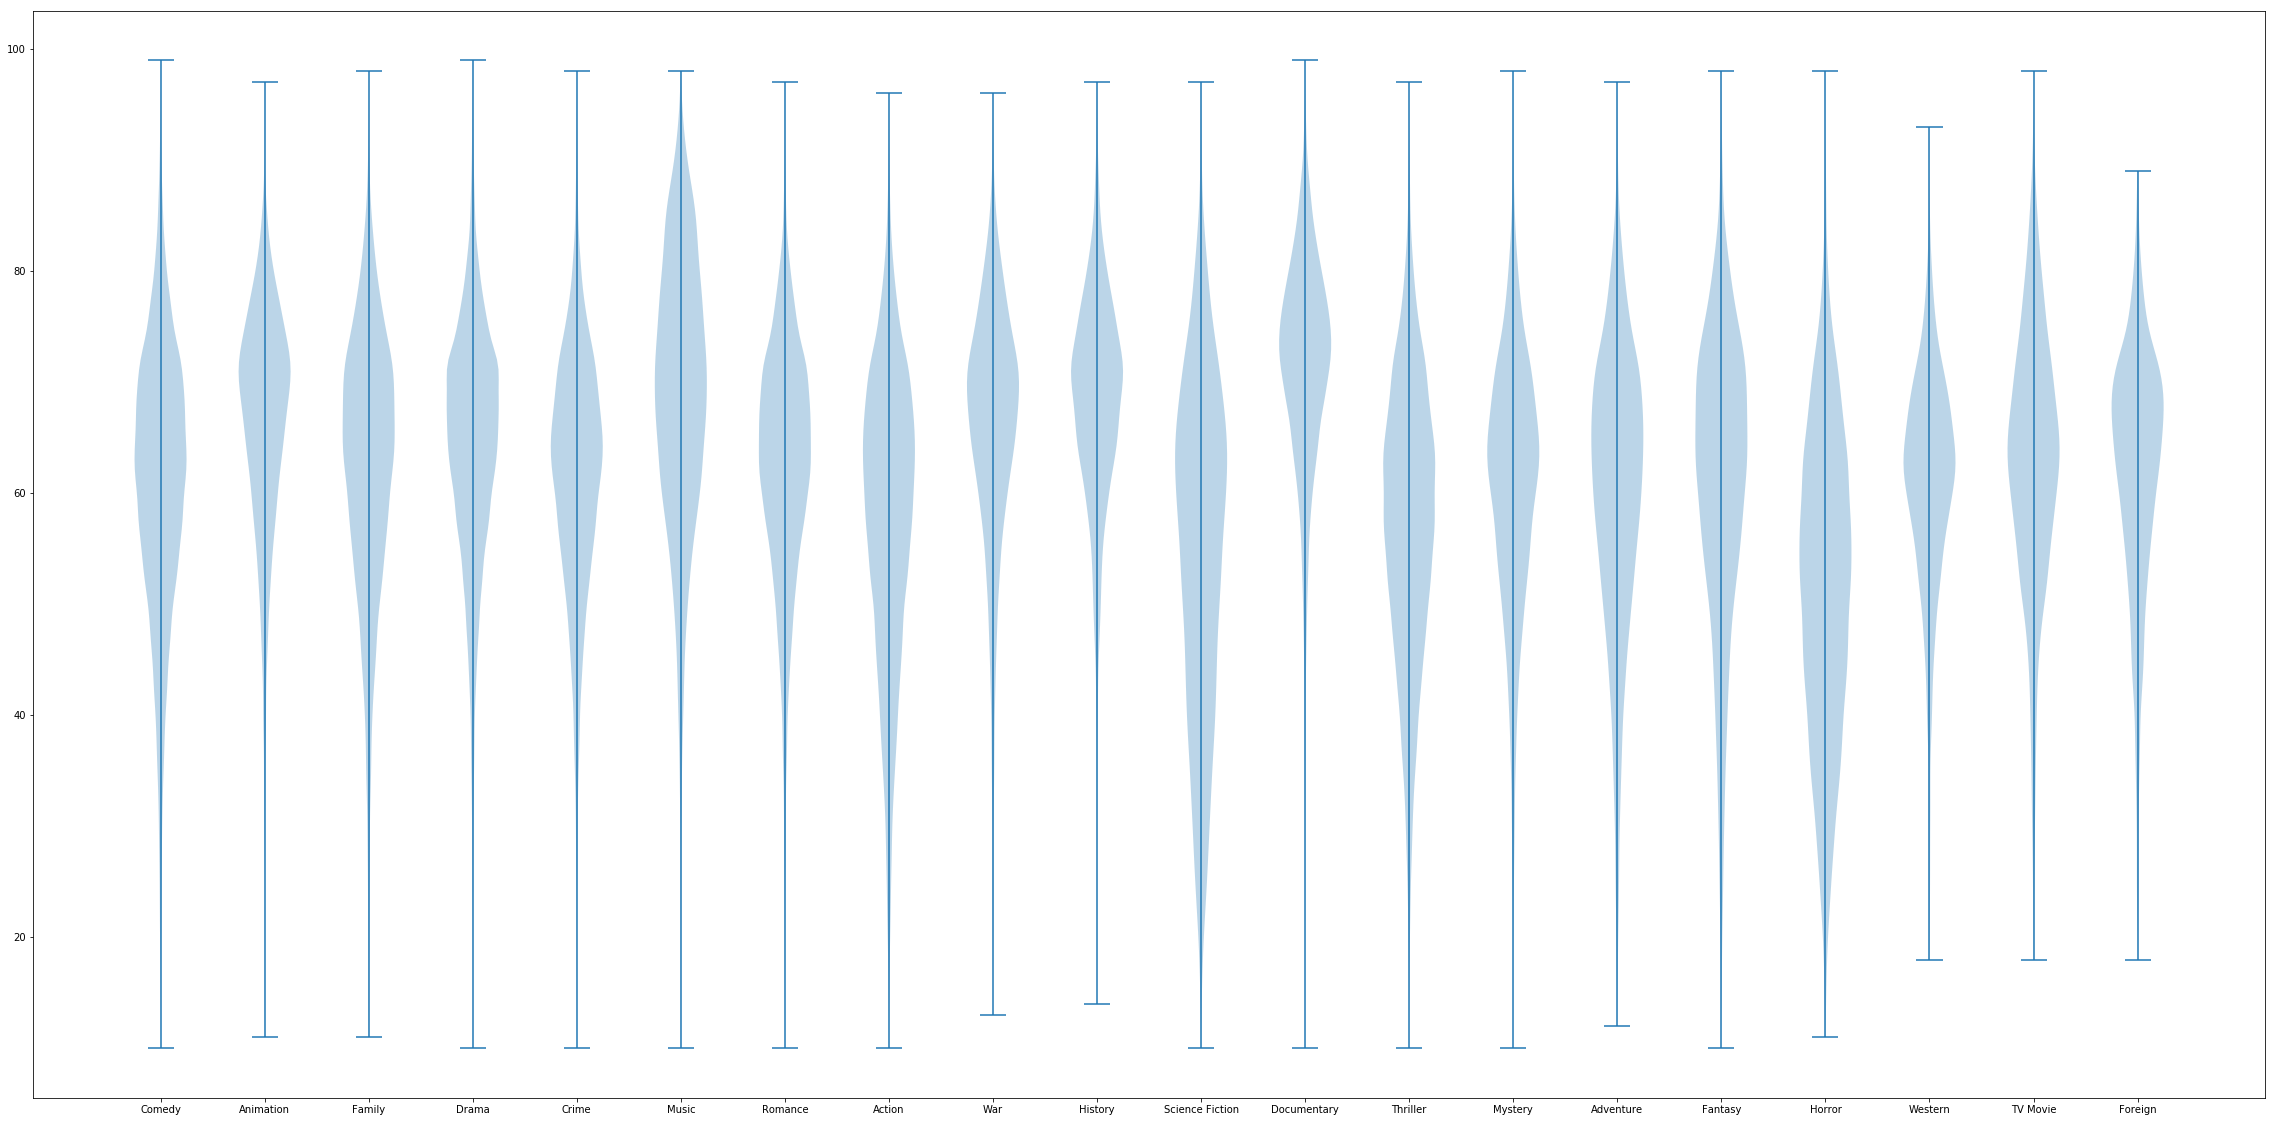

In [9]:
plt.figure( figsize=(40, 20))
pos=list(range(1, 21))
ax = plt.subplot(111)
plt.violinplot(genres_dict.values())
ax.set_xticks(pos)
ax.set_xticklabels(genres_dict.keys())
plt.show()

# Boxplot by genres

In [5]:
genres_dict={}
vote_sum=0
vote_count=0
for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    for genre in row_genres:
        if genre['name'] not in genres_dict:
            genres_dict[genre['name']]=[]
        genres_dict[genre['name']].append(row['rating'])
    vote_sum=vote_sum+int(row['rating'])
    vote_count=vote_count+1
labels= genres_dict.keys()
data=genres_dict.values()
avg=vote_sum/vote_count

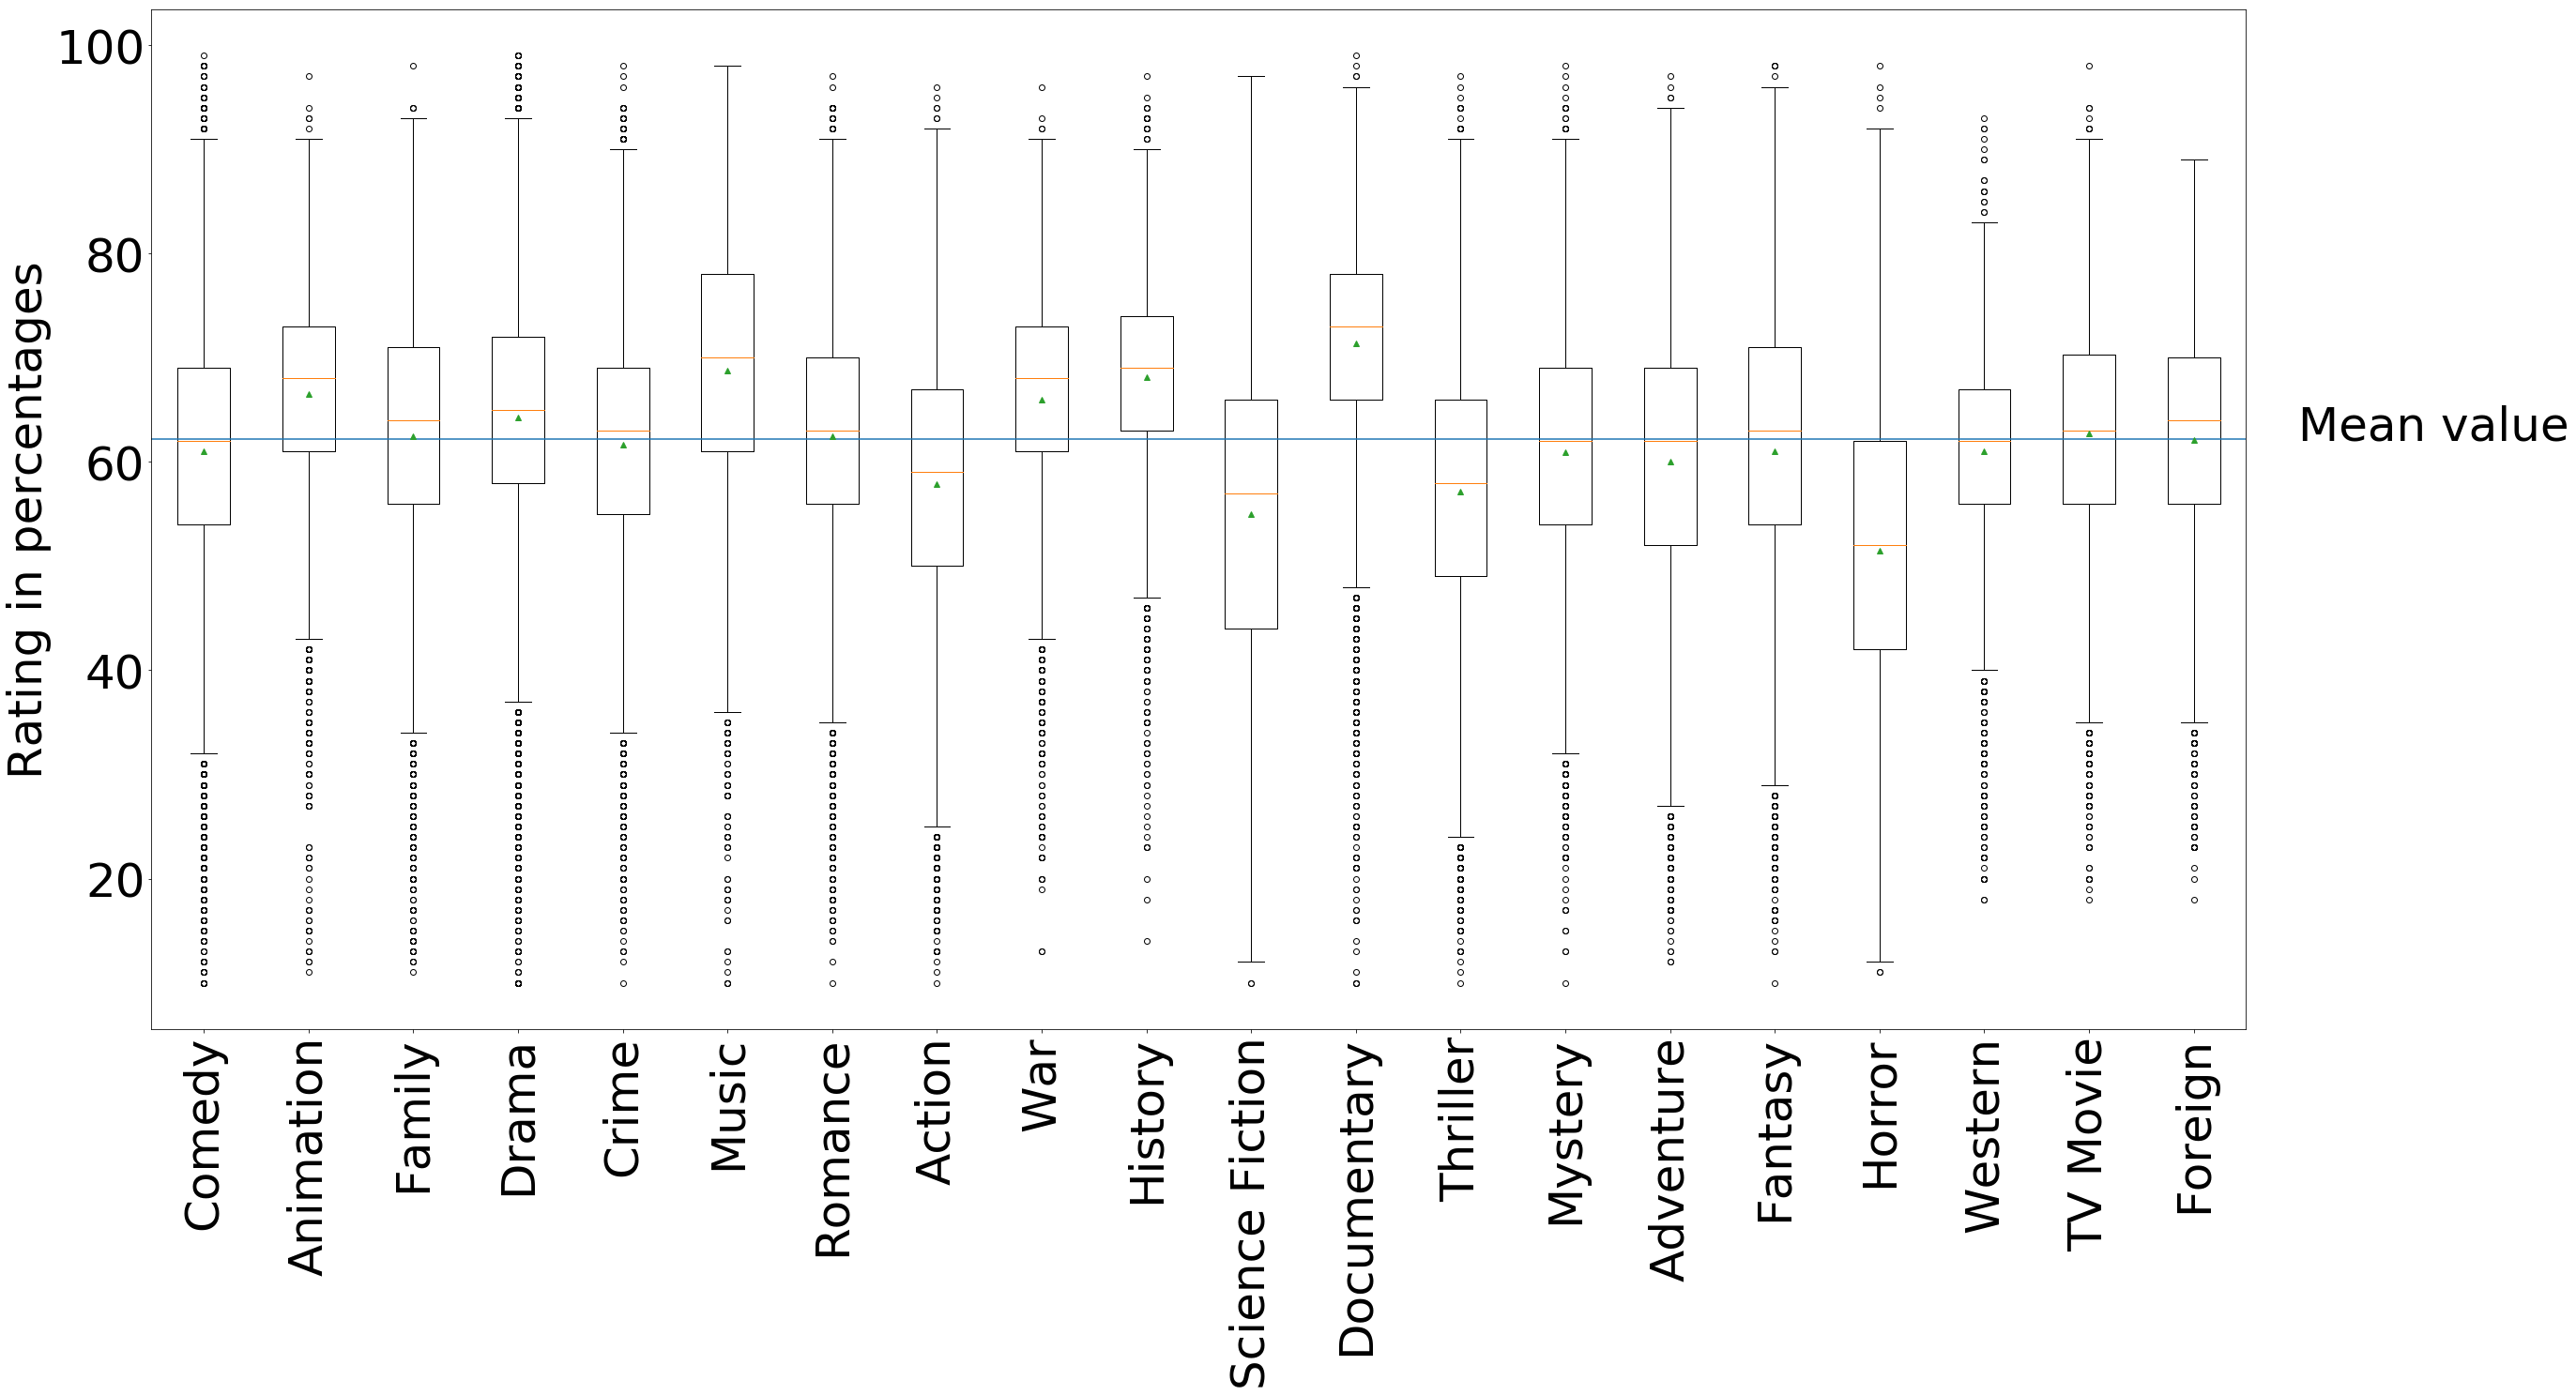

In [6]:
plt.figure( figsize=(40, 20))
plt.boxplot(data,labels=labels,showmeans=True)
plt.xticks(rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('Rating in percentages',fontsize=50)
plt.axhline(y=avg)
plt.text(21,avg,"Mean value",fontsize=50)
plt.show()

# Barchart of each genre

In [7]:
genres_dict={}
for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    for genre in row_genres:
        if genre['name'] not in genres_dict:
            genres_dict[genre['name']]=0
        genres_dict[genre['name']]= genres_dict[genre['name']]+1       

labels= genres_dict.keys()
data=genres_dict.values()

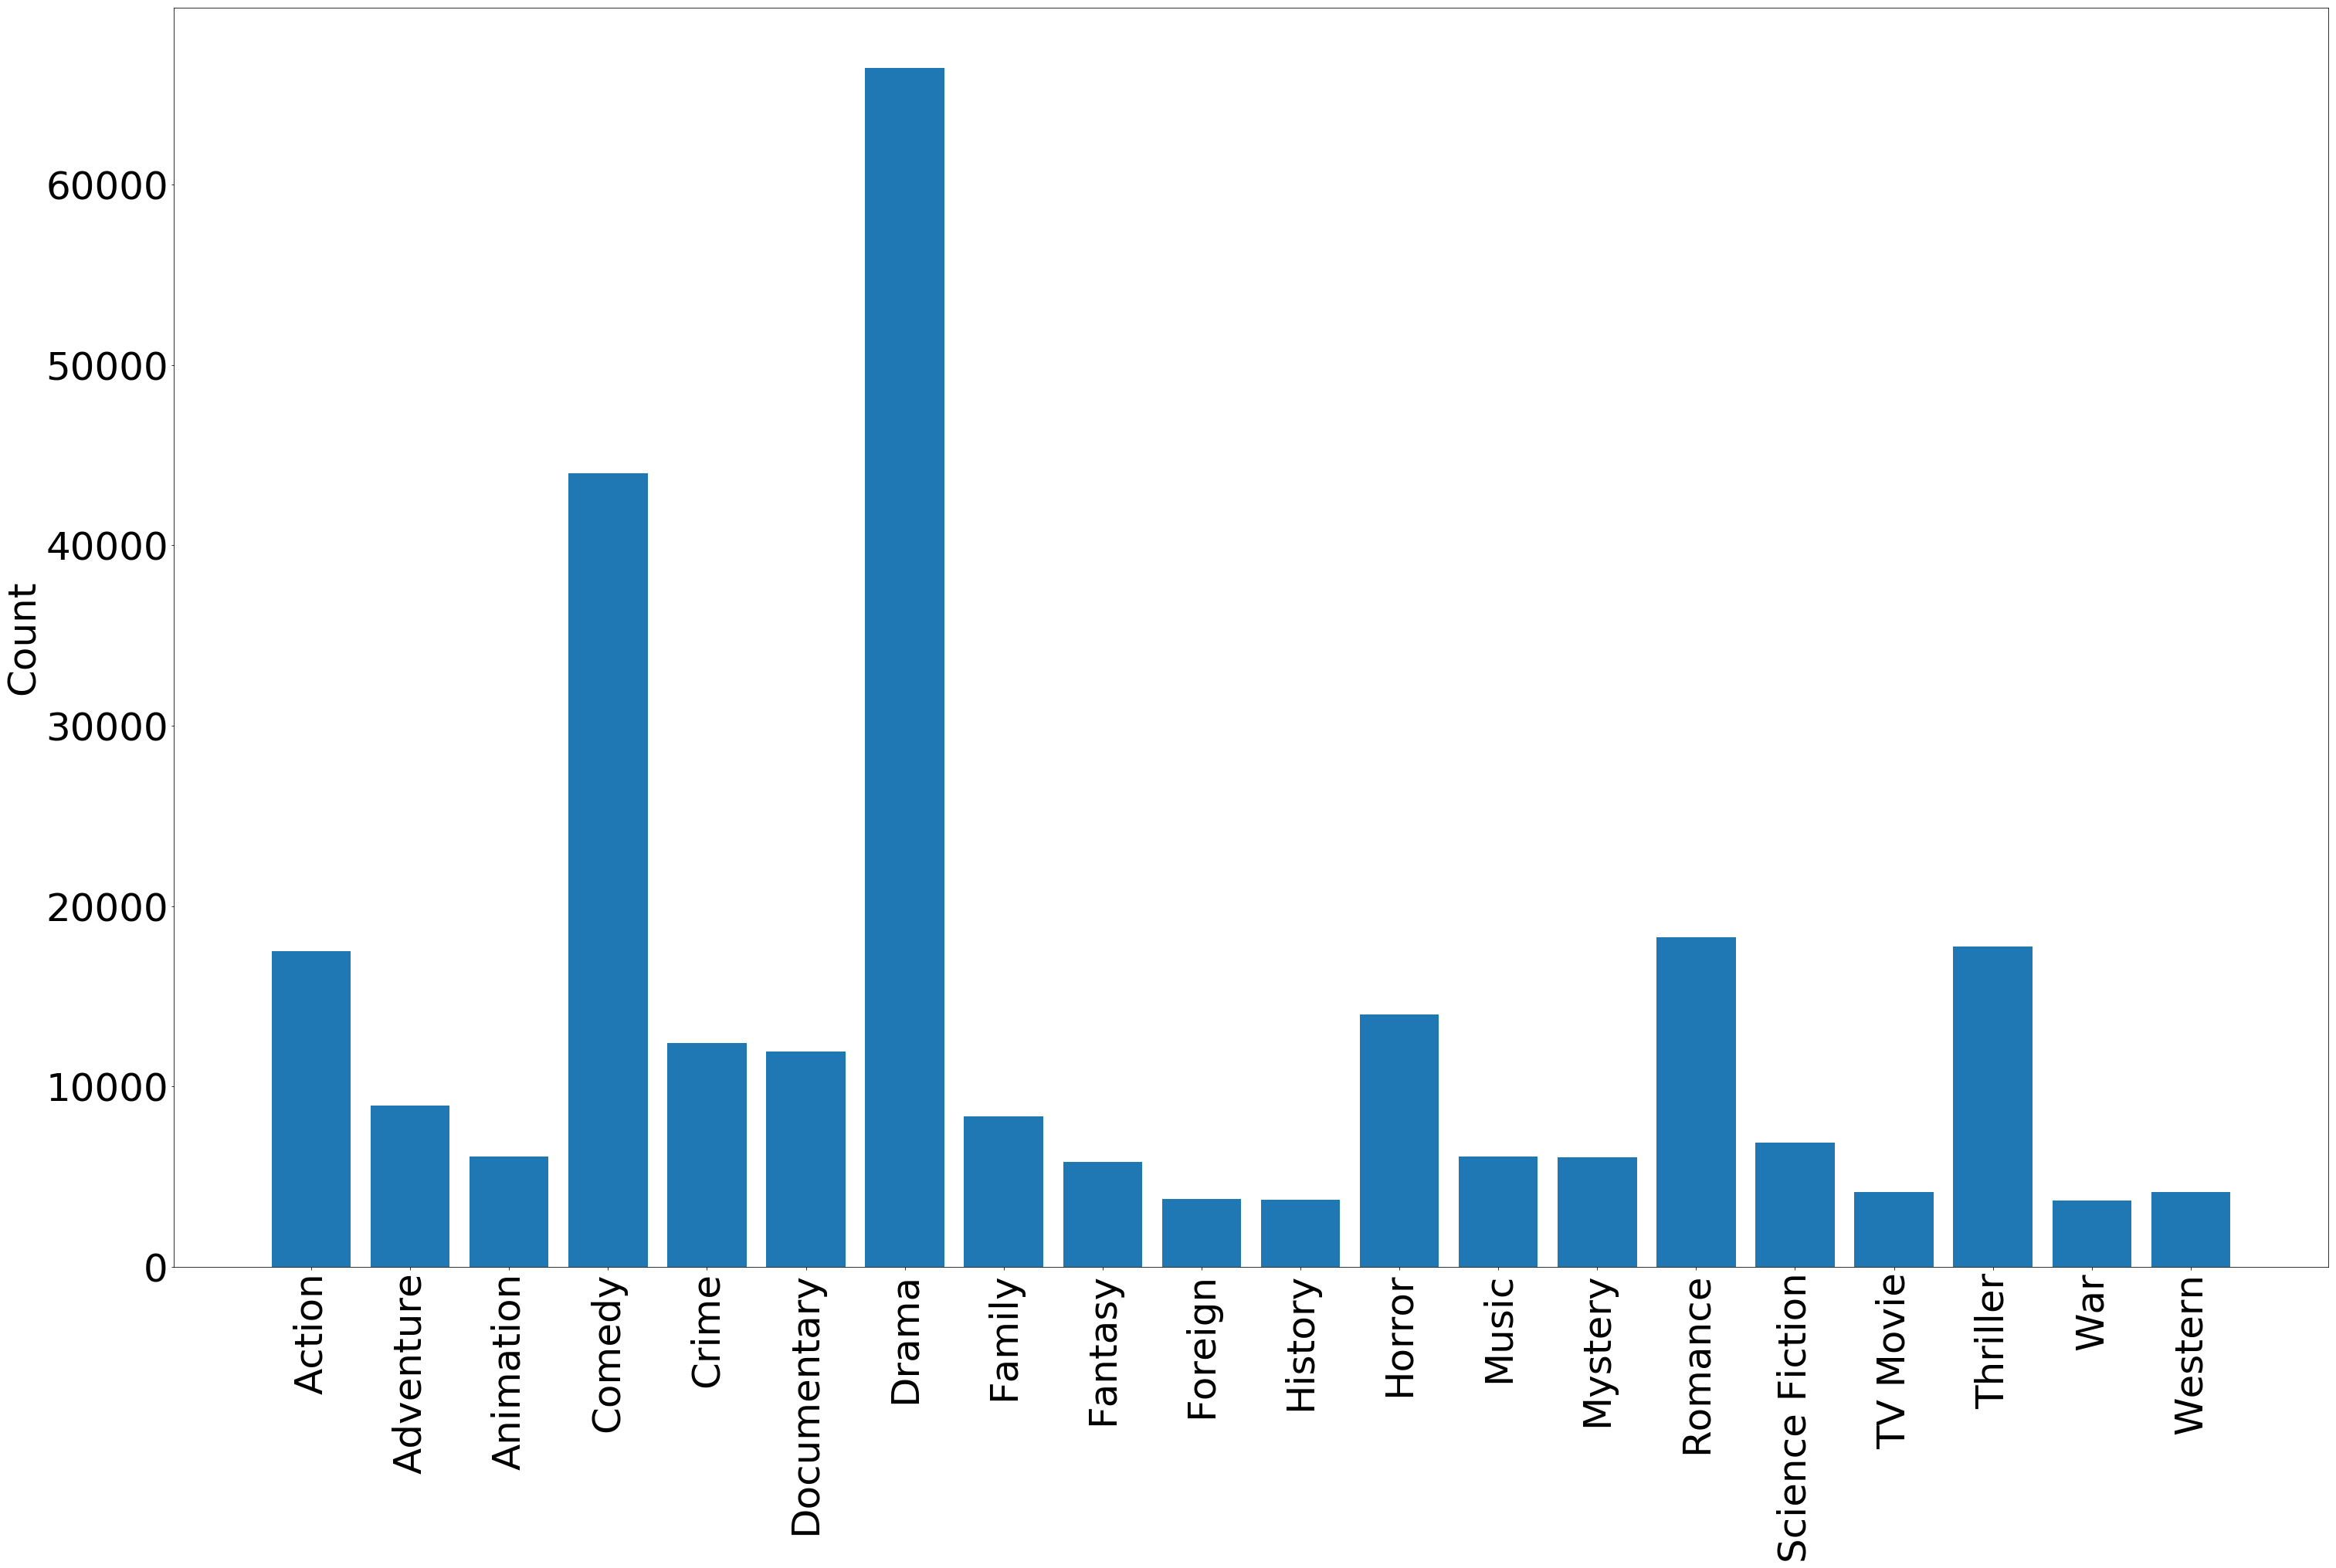

In [8]:
plt.figure( figsize=(50, 30))
plt.bar(labels, data)
plt.xticks(rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('Count',fontsize=50)
plt.show()

# Genres of most popular movies

In [ ]:
genres_dict={}
for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    if(row['popularity']<=50):
        continue
    for genre in row_genres:
        if genre['name'] not in genres_dict:
            genres_dict[genre['name']]=[]
        genres_dict[genre['name']].append(row['popularity'])
    
labels= genres_dict.keys()
data=genres_dict.values()

In [ ]:
plt.figure( figsize=(40, 20))
plt.boxplot(data,labels=labels,showmeans=True)
plt.xticks(rotation=90,fontsize=20)
plt.show()

# Count the number of movies for companies

In [ ]:
companies_dict={}
for index, row in test_data.iterrows():
    row_companies=ast.literal_eval(row['production_companies'])
    for company in row_companies:
        if company['name'] not in companies_dict:
            companies_dict[company['name']]=0
        companies_dict[company['name']]=companies_dict[company['name']]+1   

In [ ]:
sorted_x = sorted(companies_dict.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
company_list=[]
for key, value in companies_dict.items():
    if (value>=50):
        company_list.append(key)

In [ ]:
companies_dict={}
vote_sum=0
vote_count=0
for index, row in test_data.iterrows():
    row_companies=ast.literal_eval(row['production_companies'])
    if(row['vote_count']==0):
        continue
    for company in row_companies:
        if company['name'] not in company_list:
            continue
        if company['name'] not in companies_dict:
            companies_dict[company['name']]=[]
        companies_dict[company['name']].append(row['vote_average'])
    vote_sum=vote_sum+int(row['vote_average'])
    vote_count=vote_count+1
labels=companies_dict.keys()
data=companies_dict.values()

avg=vote_sum/vote_count

plt.figure( figsize=(40, 20))
plt.boxplot(data,labels=labels,showmeans=True)
plt.xticks(rotation=90)
plt.axhline(y=avg)
plt.show()

# Numeric data for correlation

In [4]:
corr_data=test_data[['rating','rating_count','adult','runtime','release_date','budget_moviedb',
                     'revenue_moviedb','budget_imdb','revenue_imdb','revenue_USA']].copy()
corr_data['release_date']=corr_data['release_date'].str[:-6]
corr_data = corr_data[pd.notnull(corr_data['release_date'])]
corr_data['release_date']=(corr_data['release_date']).astype(int)
corr_data = corr_data.reset_index(drop=True)


In [5]:
corr_data['revenue']=corr_data['revenue_moviedb']
corr_data['revenue']=corr_data['revenue'].replace(0, np.nan)
corr_data['revenue']=corr_data['revenue'].fillna(corr_data['revenue_imdb'])
corr_data['revenue']=corr_data['revenue'].fillna(corr_data['revenue_USA'])
corr_data['revenue']=corr_data['revenue'].fillna(0)

corr_data['budget']=corr_data['budget_moviedb']
corr_data['budget']=corr_data['budget'].replace(0, np.nan)
corr_data['budget']=corr_data['budget'].fillna(corr_data['budget_imdb'])
corr_data['budget']=corr_data['budget'].fillna(0)

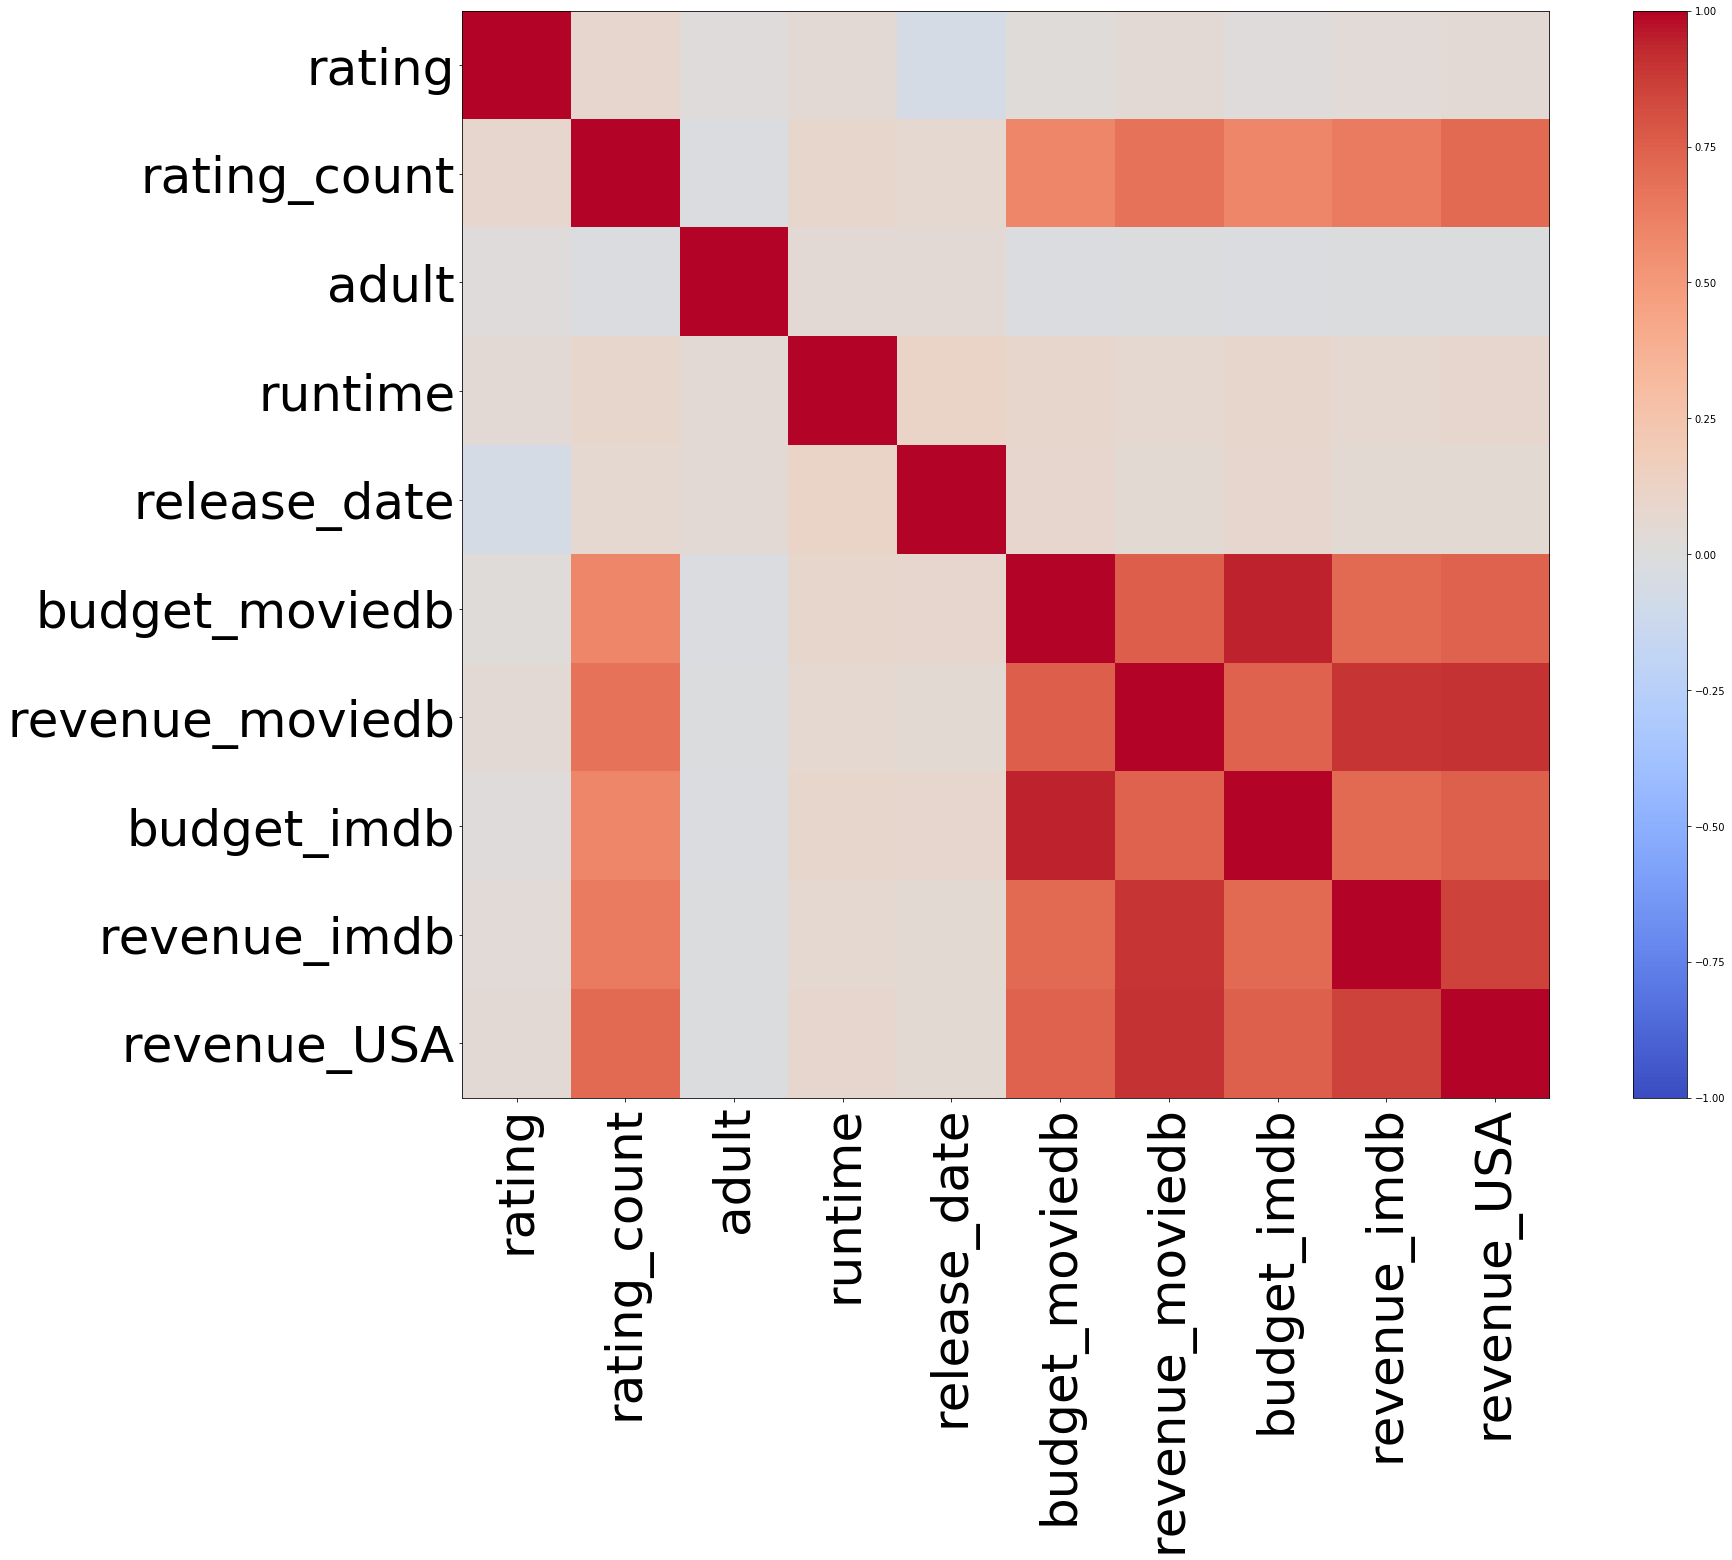

In [11]:
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(30)

image=ax.matshow(corr_data.corr(),interpolation='nearest', cmap=cm.coolwarm,vmin=-1, vmax=1)
colorbar=fig.colorbar(image)

labels=['rating','rating_count','adult','runtime','release_date','budget_moviedb','revenue_moviedb',
        'budget_imdb','revenue_imdb','revenue_USA']

ax.set_xticklabels([''] + labels,fontsize=50)
ax.set_yticklabels([''] + labels,fontsize=50)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
od=plt.xticks(rotation='vertical')

# Pairplot

In [14]:
corr_data['rounded_rating']=corr_data['rating'].apply(lambda x: int(round(x/10))*10)
sliced=corr_data.loc[:15000,'rating_count':]
sliced=sliced.drop(['budget','revenue'],axis=1)

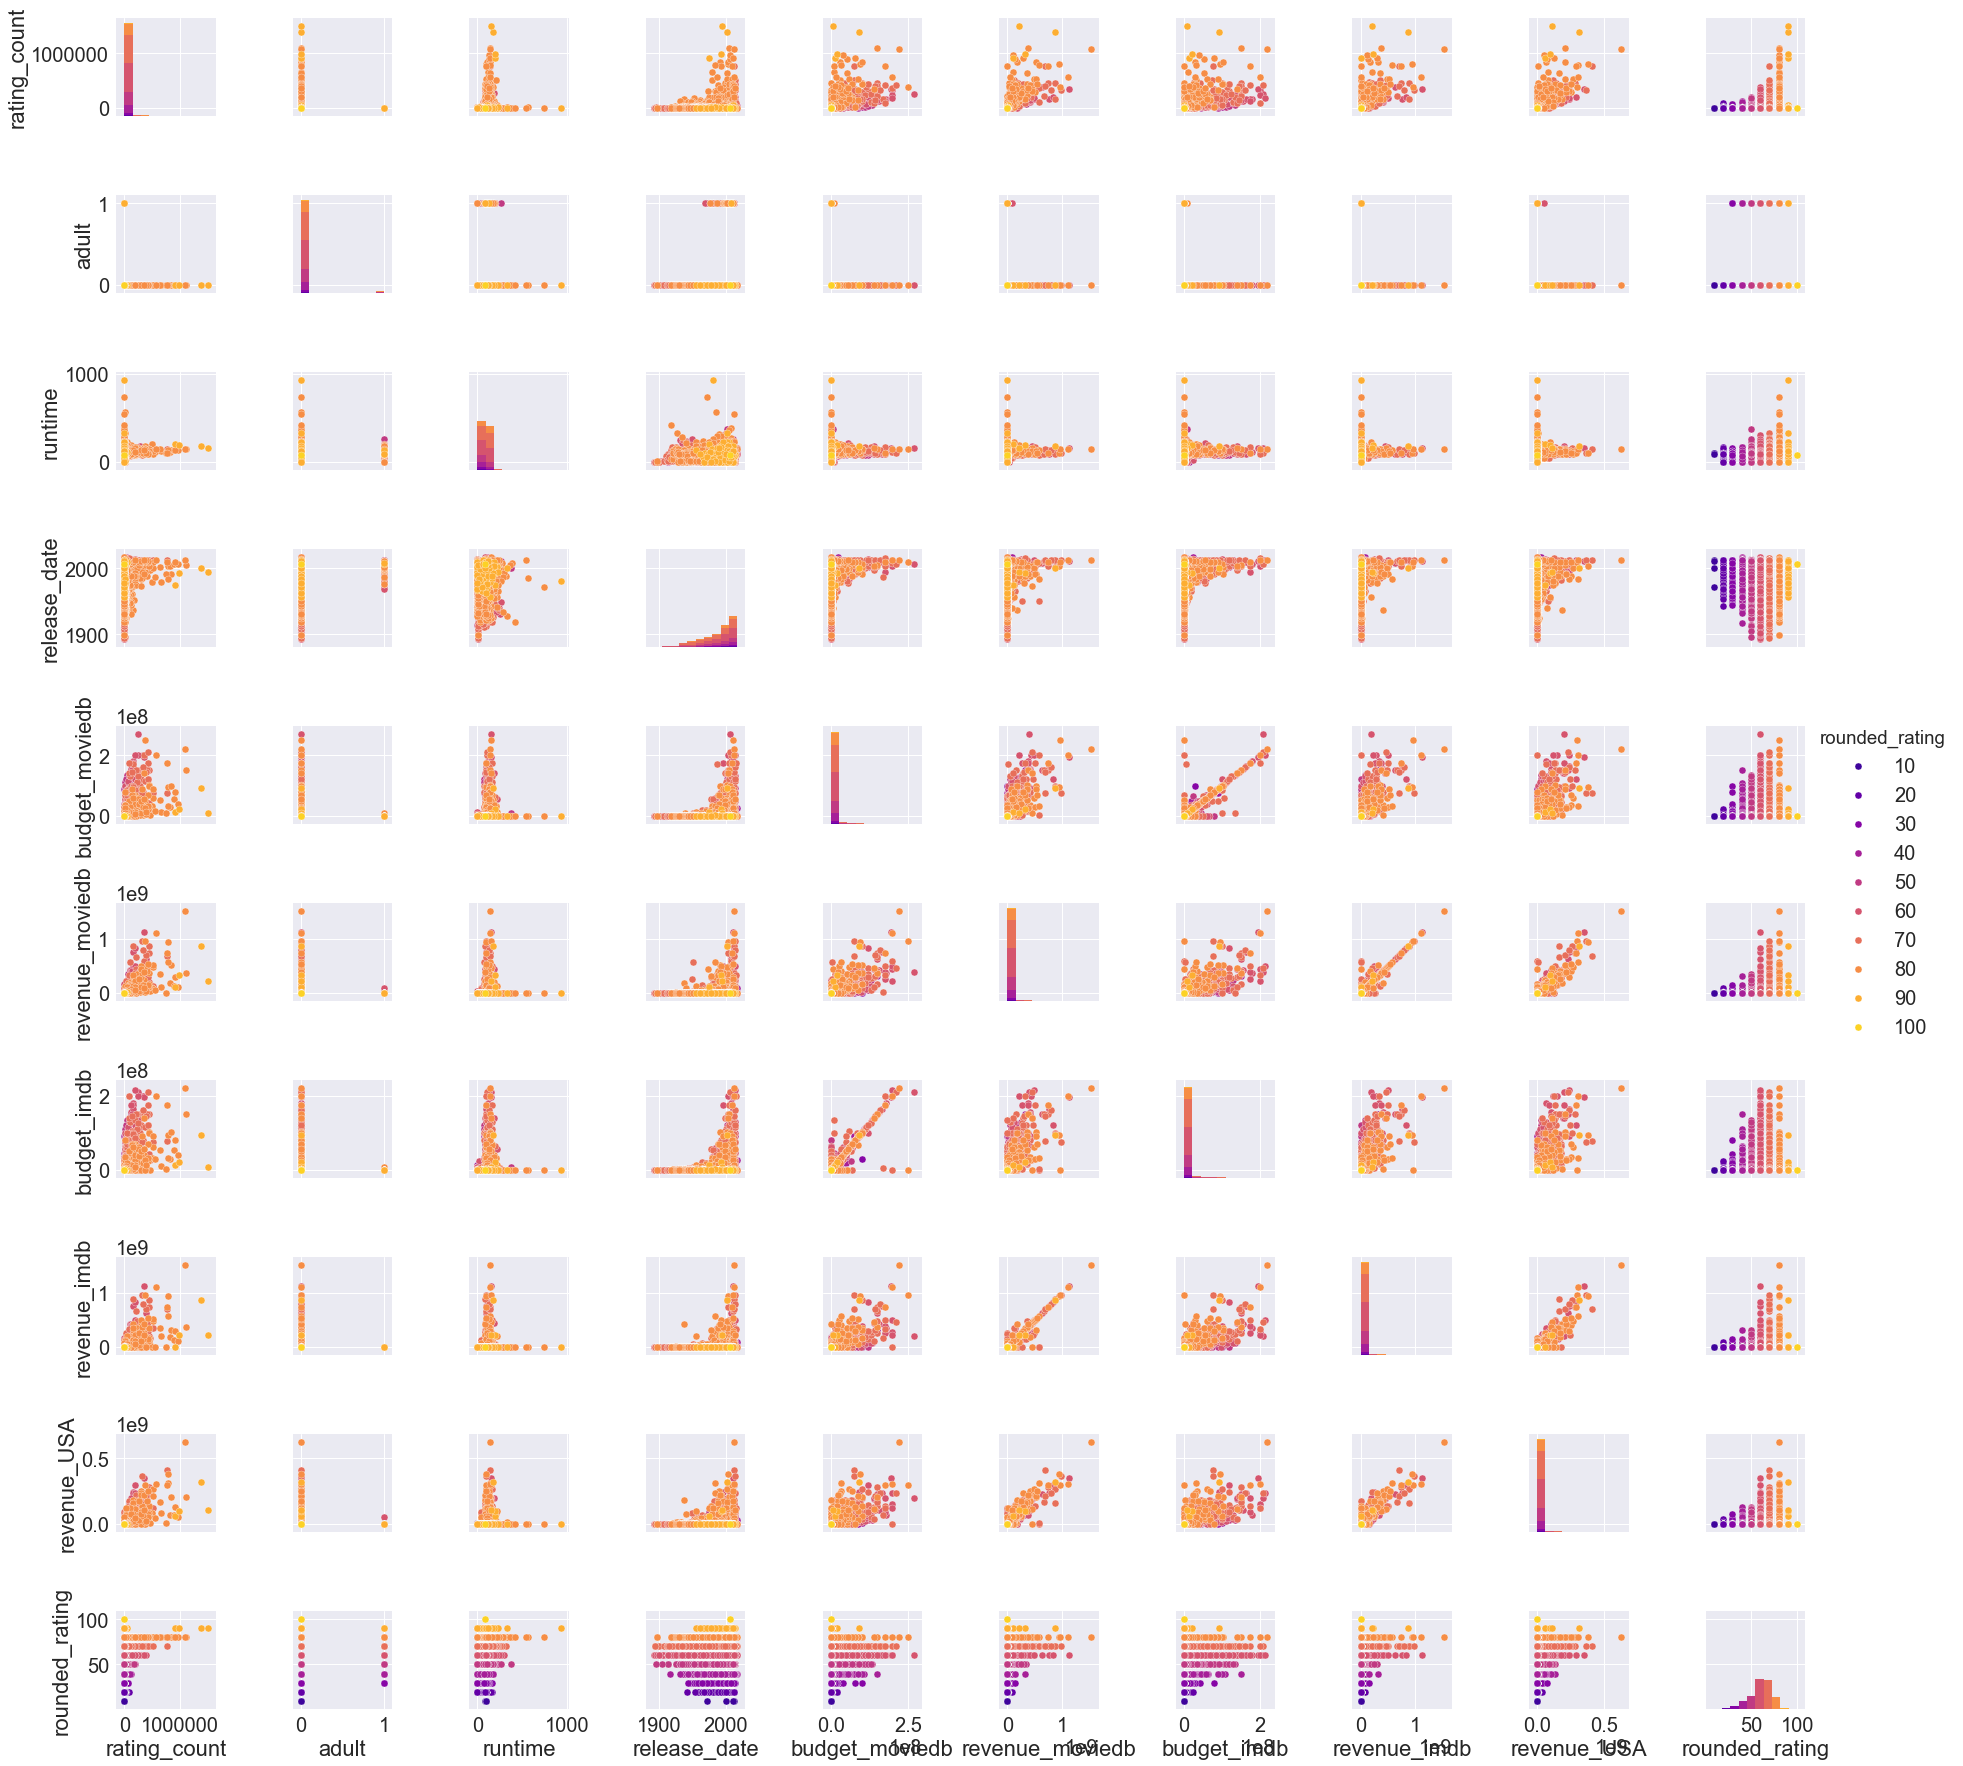

In [20]:
sns.set(font_scale=2)
sns.pairplot(sliced,hue='rounded_rating',palette='plasma')

# Budget/Avg. Revenue graph

In [22]:
budget_dict={}
for index, row in corr_data.iterrows():
    if int(row['budget']) < 10000 or int(row['revenue']<10000):
        continue
    if row['budget'] not in budget_dict:
           budget_dict[row['budget']]=[0,0]
    budget_dict[row['budget']][1]=budget_dict[row['budget']][1]+1
    budget_dict[row['budget']][0]=budget_dict[row['budget']][0]+row['revenue']

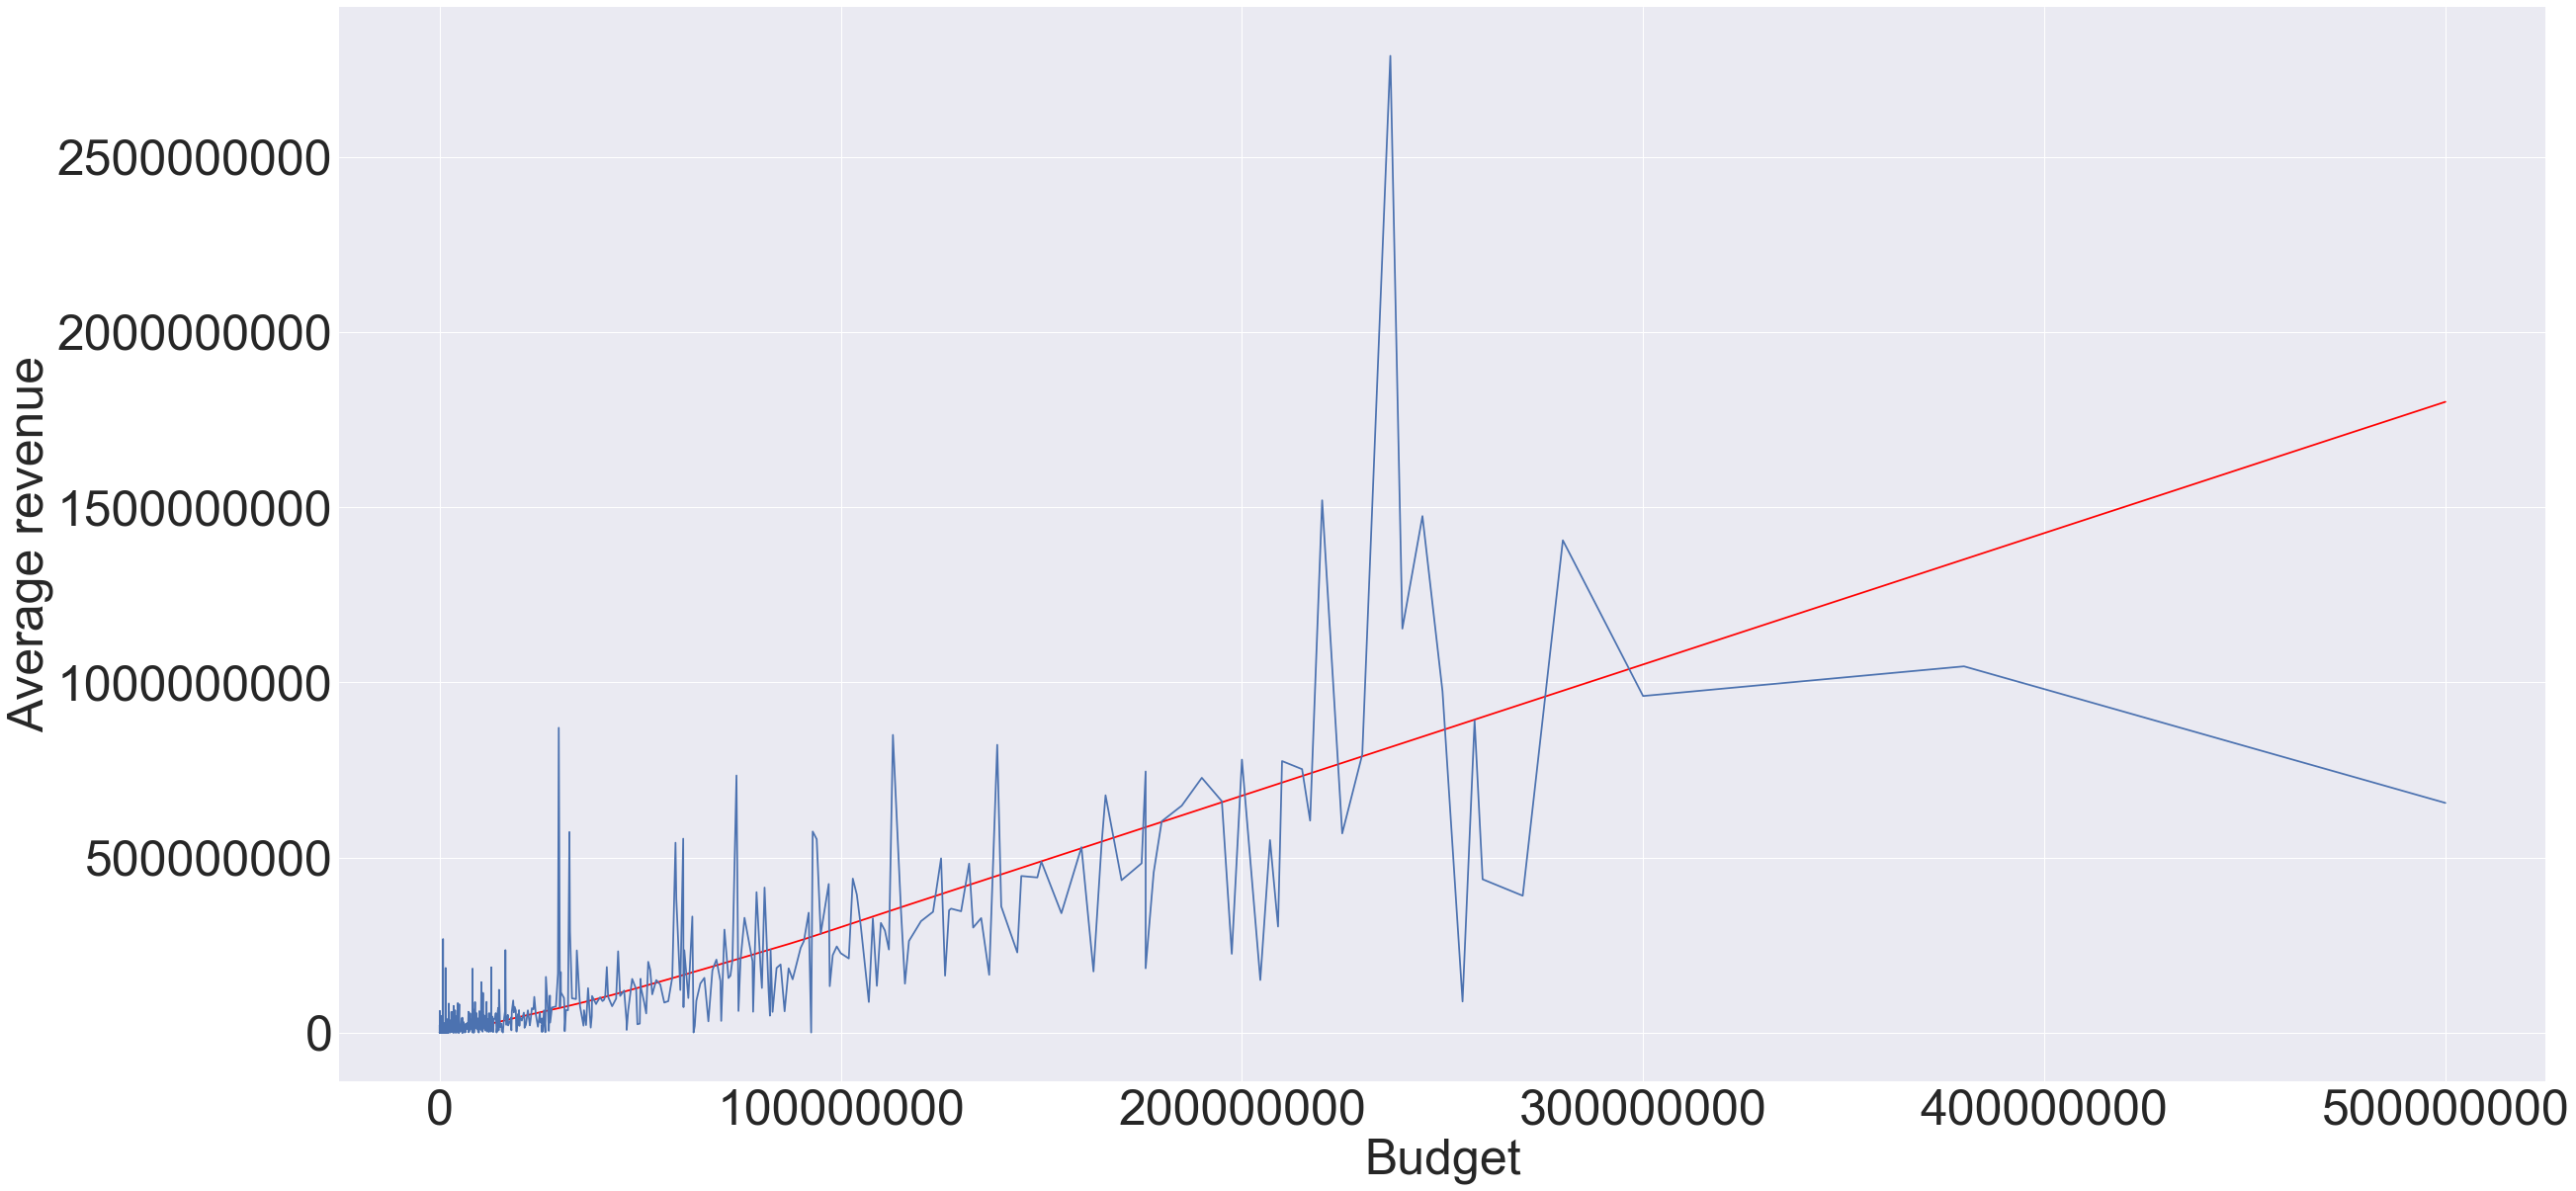

In [23]:
sorted_budget = sorted(budget_dict.items())
budget, abs_revenue = zip(*sorted_budget)
avg_revenue = [y[0]/y[1] for y in abs_revenue]

# x_pred = np.linspace(budget[0], budget[-1], 100)
# gp = GaussianProcess(theta0=1, thetaL=0.002, thetaU=100, nugget=0.00001)
# gp.fit(np.atleast_2d(budget).T, avg_revenue)
# y_pred = gp.predict(np.atleast_2d(x_pred).T)
b=np.array(budget)
a=np.array(avg_revenue)

smooth=lw.lowess(b,a,f=0.2, iter=10)


plt.figure( figsize=(40, 20))

plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

plt.xlabel('Budget',fontsize=50)
plt.ylabel('Average revenue',fontsize=50)
plt.ticklabel_format(axis='both',useOffset=False,style='plain')
#plt.plot(x_pred, y_pred, color='green')
plt.plot(budget,smooth, color='red')
plt.plot(budget, avg_revenue)

plt.show()

# Scatterplot of budget/revenue

In [25]:
x_genre=[]
y_score=[]
z_color=[]

for index, row in corr_data.iterrows():
    if row['revenue']==0 or row['budget']==0:
        continue
    if row['revenue']<2000000000 and row['budget']<2000000000:
        x_genre.append(row['budget'])
        y_score.append(row['revenue'])     
        z_color.append(row['rating'])


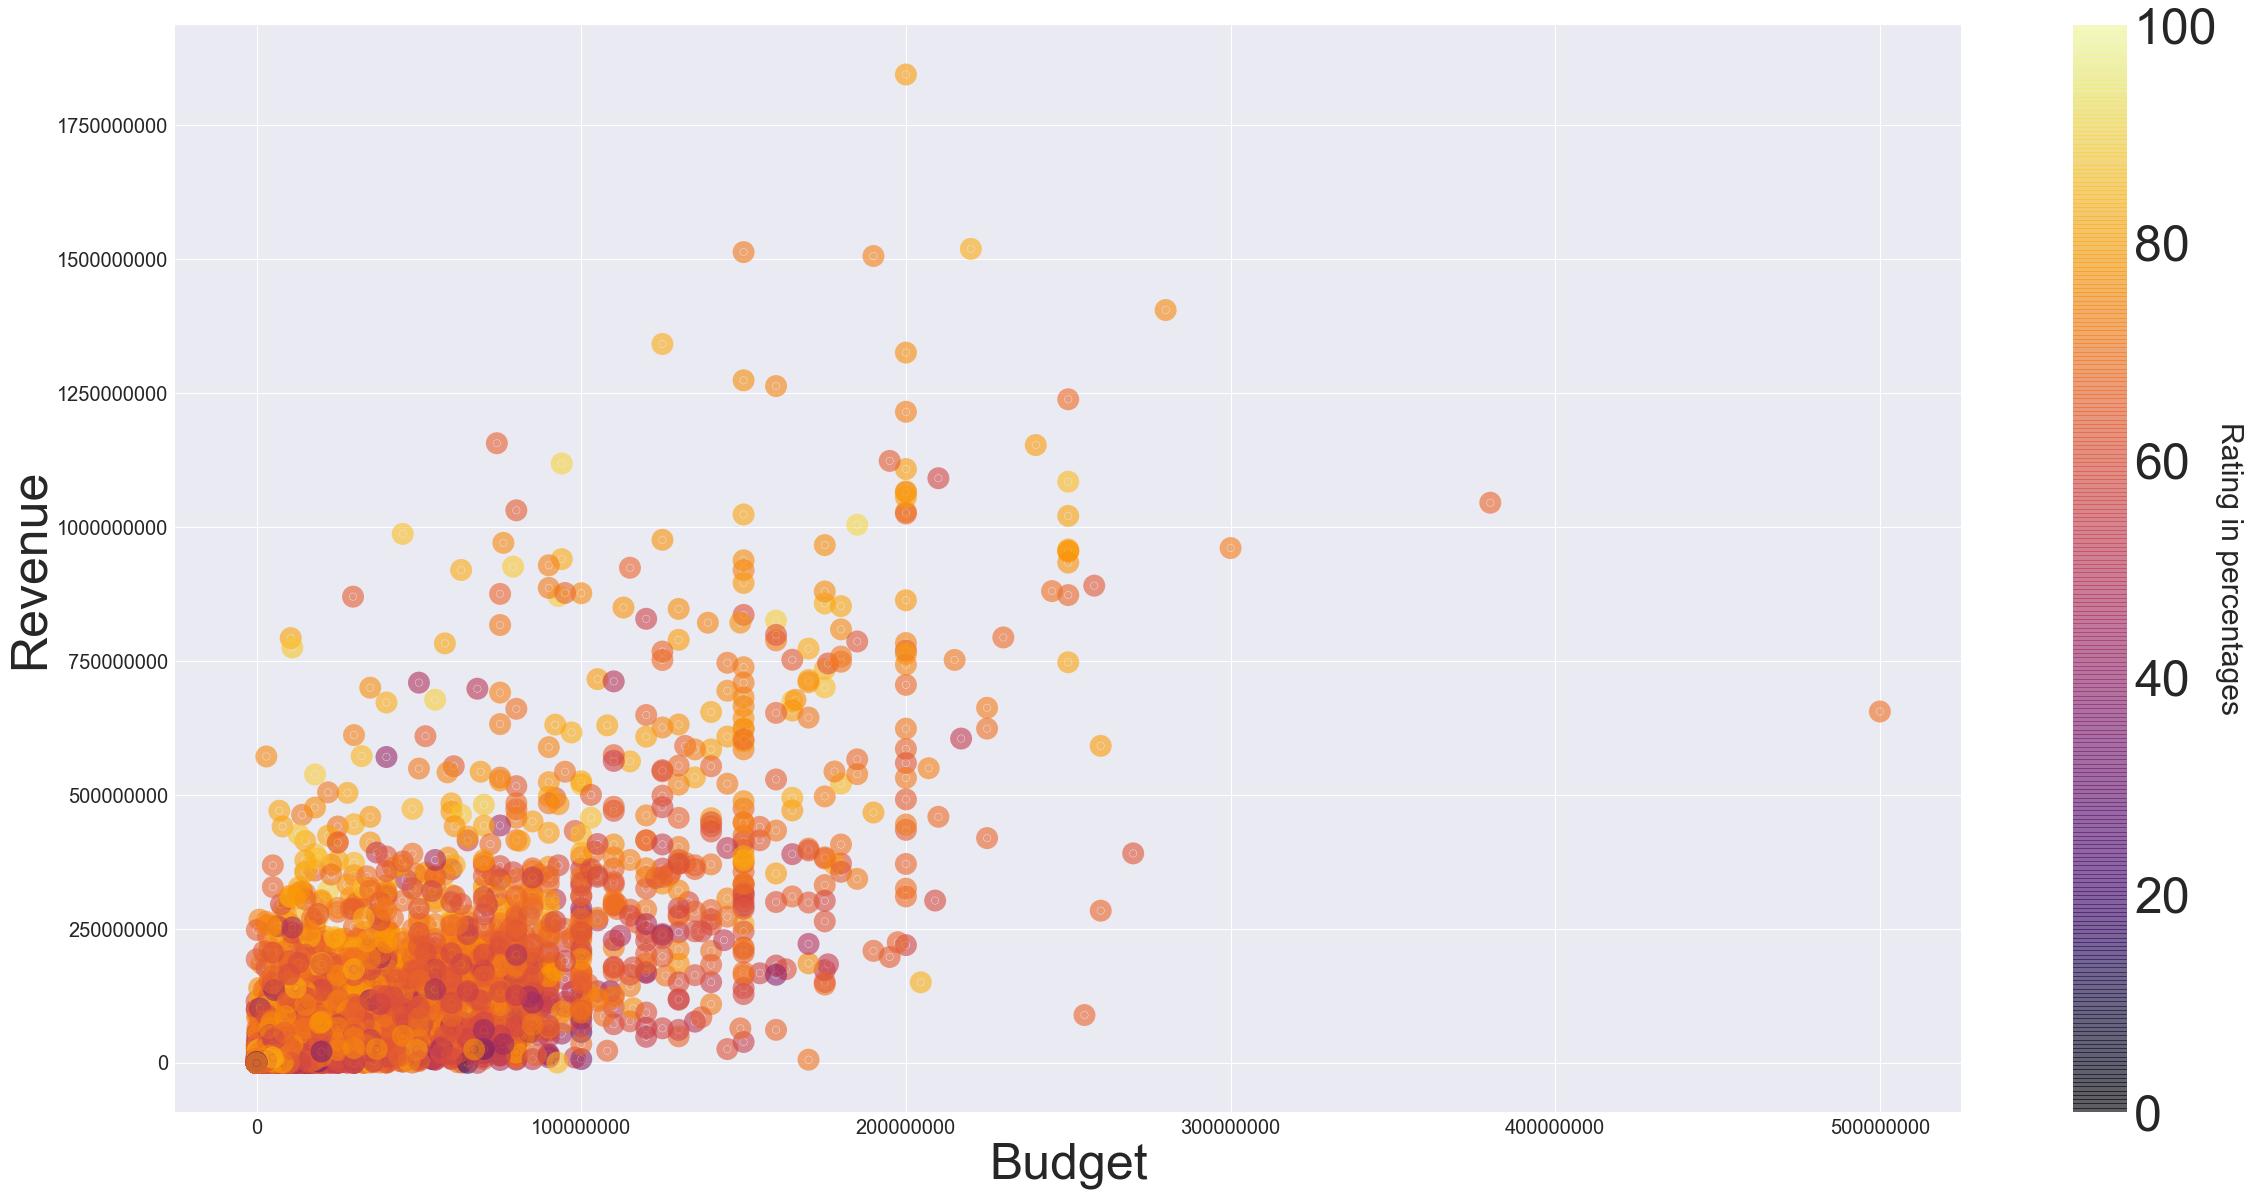

In [26]:
plt.figure( figsize=(40, 20))        
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel('Budget',fontsize=50)
plt.ylabel('Revenue',fontsize=50)
plt.ticklabel_format(axis='both',useOffset=False,style='plain')        
        
    
plt.scatter(x_genre, y_score, c=z_color,alpha=0.6,linewidths=15,cmap='inferno')
cb=plt.colorbar() 
cb.ax.tick_params(labelsize=50) 
cb.ax.set_ylabel('Rating in percentages', fontsize=30,rotation=270)
cb.ax.get_yaxis().labelpad = 25
plt.clim(0,100)
plt.show()

# Revenue/avg rating(unused)

In [49]:
revenue_dict_vote={}
for index, row in corr_data.iterrows():
    if int(row['revenue']) < 1000:
        continue
    if row['revenue'] not in revenue_dict_vote:
           revenue_dict_vote[row['revenue']]=[0,0]
    revenue_dict_vote[row['revenue']][1]=revenue_dict_vote[row['revenue']][1]+1
    revenue_dict_vote[row['revenue']][0]=revenue_dict_vote[row['revenue']][0]+row['rating']

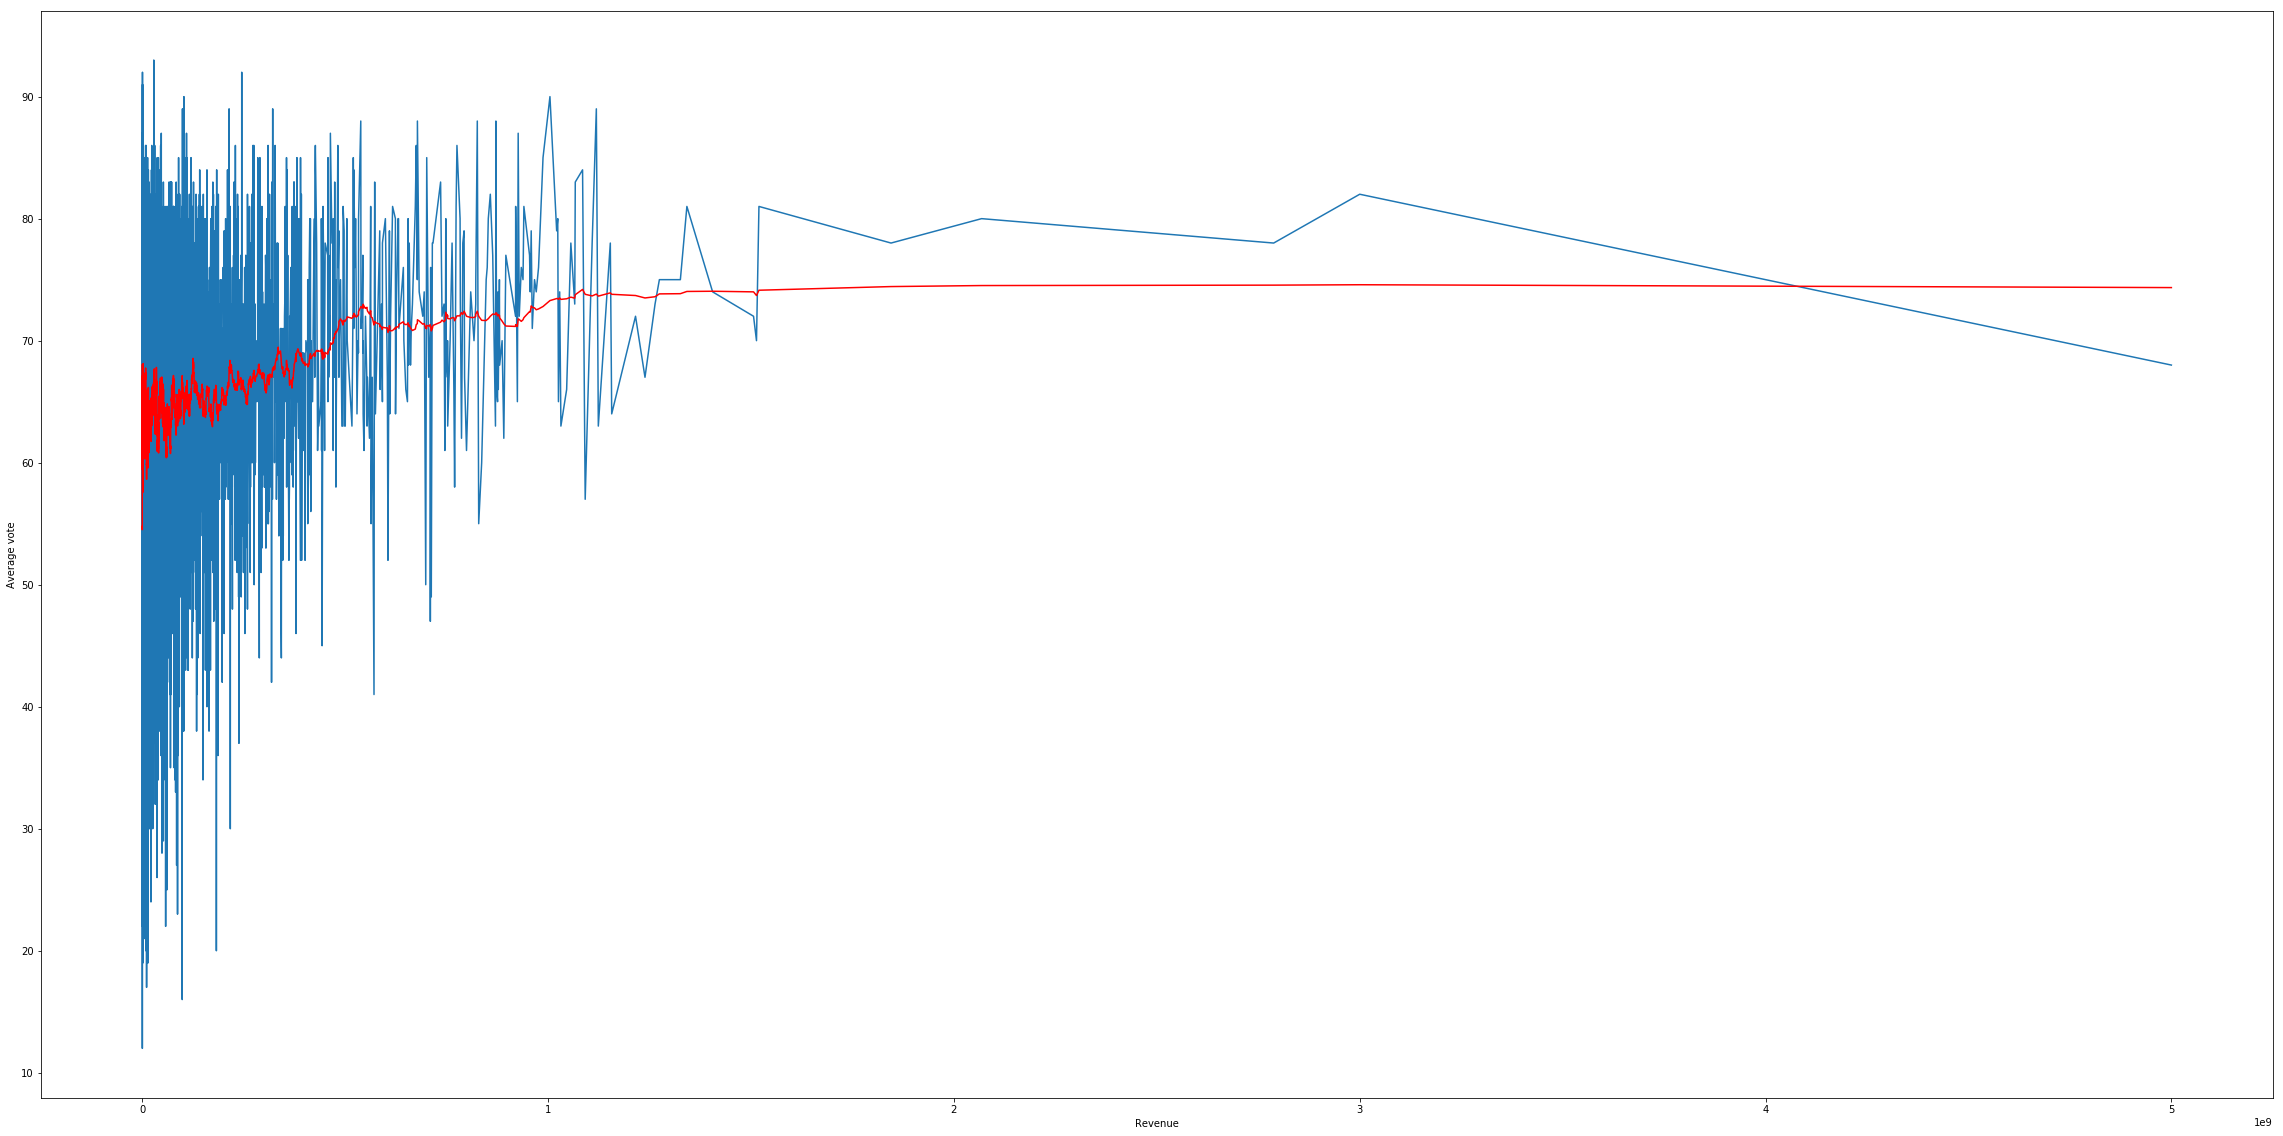

In [50]:
sorted_revenue_vote = sorted(revenue_dict_vote.items())
revenue, abs_vote = zip(*sorted_revenue_vote)
avg_vote = [y[0]/y[1] for y in abs_vote]

mad = lambda x: np.fabs(x - x.mean()).mean()

avg_vote=pd.DataFrame(avg_vote)

plt.figure( figsize=(40, 20))
plt.xlabel('Revenue')
plt.ylabel('Average vote')

test=avg_vote.rolling(window=60, win_type='boxcar').mean()
test=test.bfill()

plt.plot(revenue, avg_vote)
plt.plot(revenue,test,color='red')

plt.show()

# Runtime/avg rating

In [27]:
runtime_dict_vote={}
for index, row in corr_data.iterrows():
    if row['runtime'] == 0 or math.isnan(row['runtime']) or row['runtime']>500:
        continue
    if row['runtime'] not in runtime_dict_vote:
           runtime_dict_vote[row['runtime']]=[0,0]
    runtime_dict_vote[row['runtime']][1]=runtime_dict_vote[row['runtime']][1]+1
    runtime_dict_vote[row['runtime']][0]=runtime_dict_vote[row['runtime']][0]+row['rating']

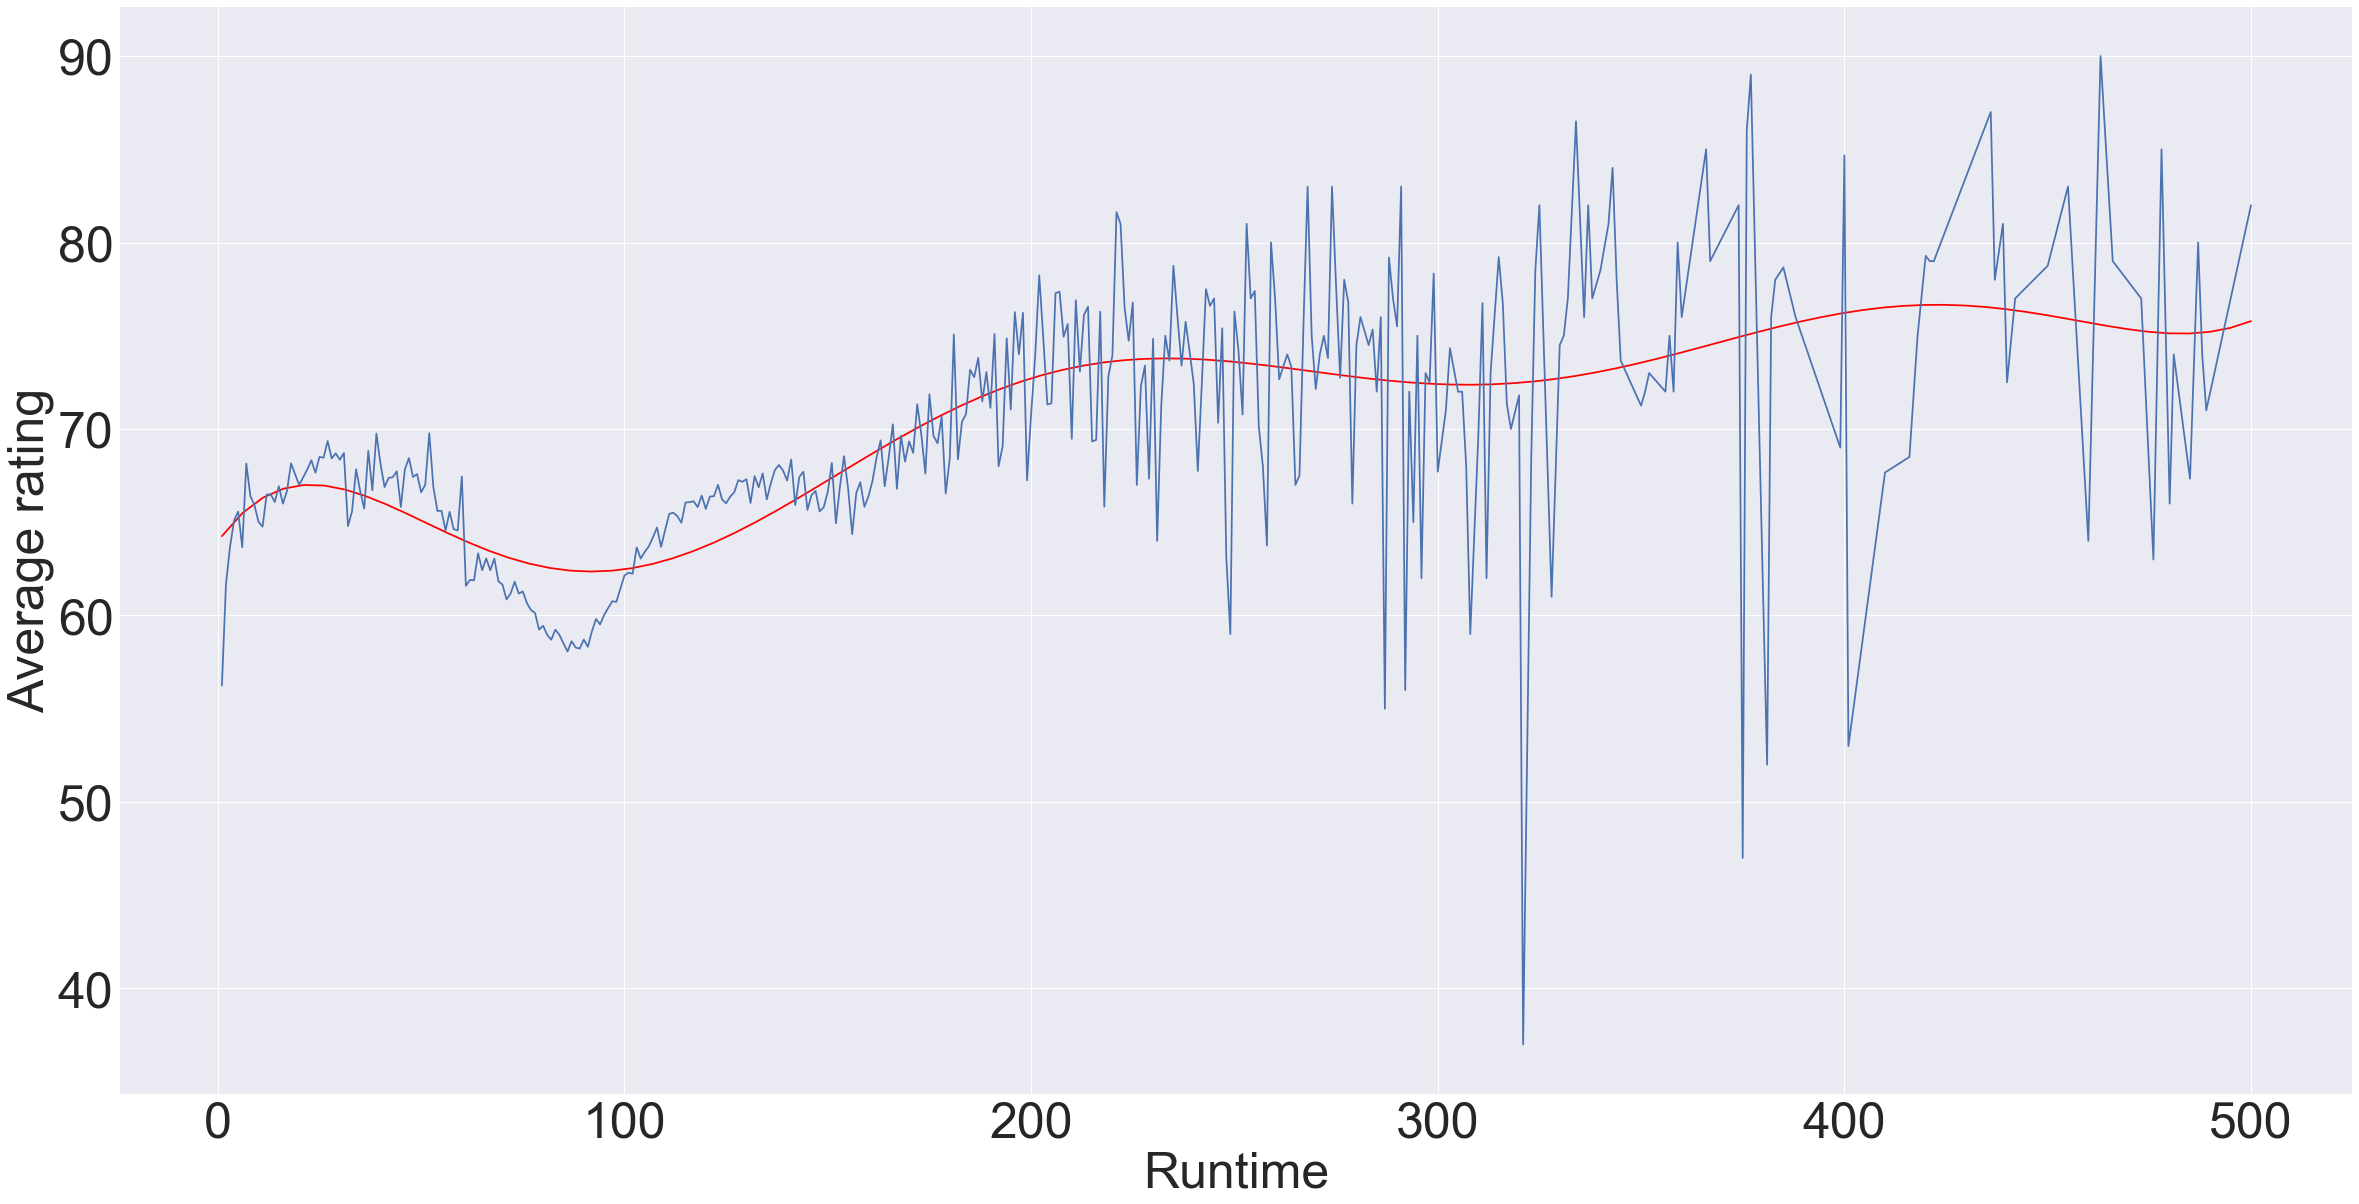

In [28]:
sorted_runtime_vote = sorted(runtime_dict_vote.items())
runtime, abs_vote = zip(*sorted_runtime_vote)
avg_vote = [y[0]/y[1] for y in abs_vote]

x_pred = np.linspace(runtime[0], runtime[-1], 100)
gp = GaussianProcess(theta0=1, thetaL=0.00001, thetaU=1000, nugget=0.000001)
gp.fit(np.atleast_2d(runtime).T, avg_vote)
y_pred = gp.predict(np.atleast_2d(x_pred).T)

plt.figure( figsize=(40, 20))
plt.xlabel('Runtime',fontsize=50)
plt.ylabel('Average rating',fontsize=50)
plt.plot(x_pred, y_pred, color='red')
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.plot(runtime, avg_vote)
plt.show()

# Release date/avg rating

In [29]:
year_dict_vote={}
for index, row in corr_data.iterrows():
    if pd.isnull(row['release_date']):
        continue
    if int(row['release_date']) not in runtime_dict_vote:
           year_dict_vote[int(row['release_date'])]=[0,0]
    year_dict_vote[int(row['release_date'])][1]=year_dict_vote[int(row['release_date'])][1]+1
    year_dict_vote[int(row['release_date'])][0]=year_dict_vote[int(row['release_date'])][0]+row['rating']

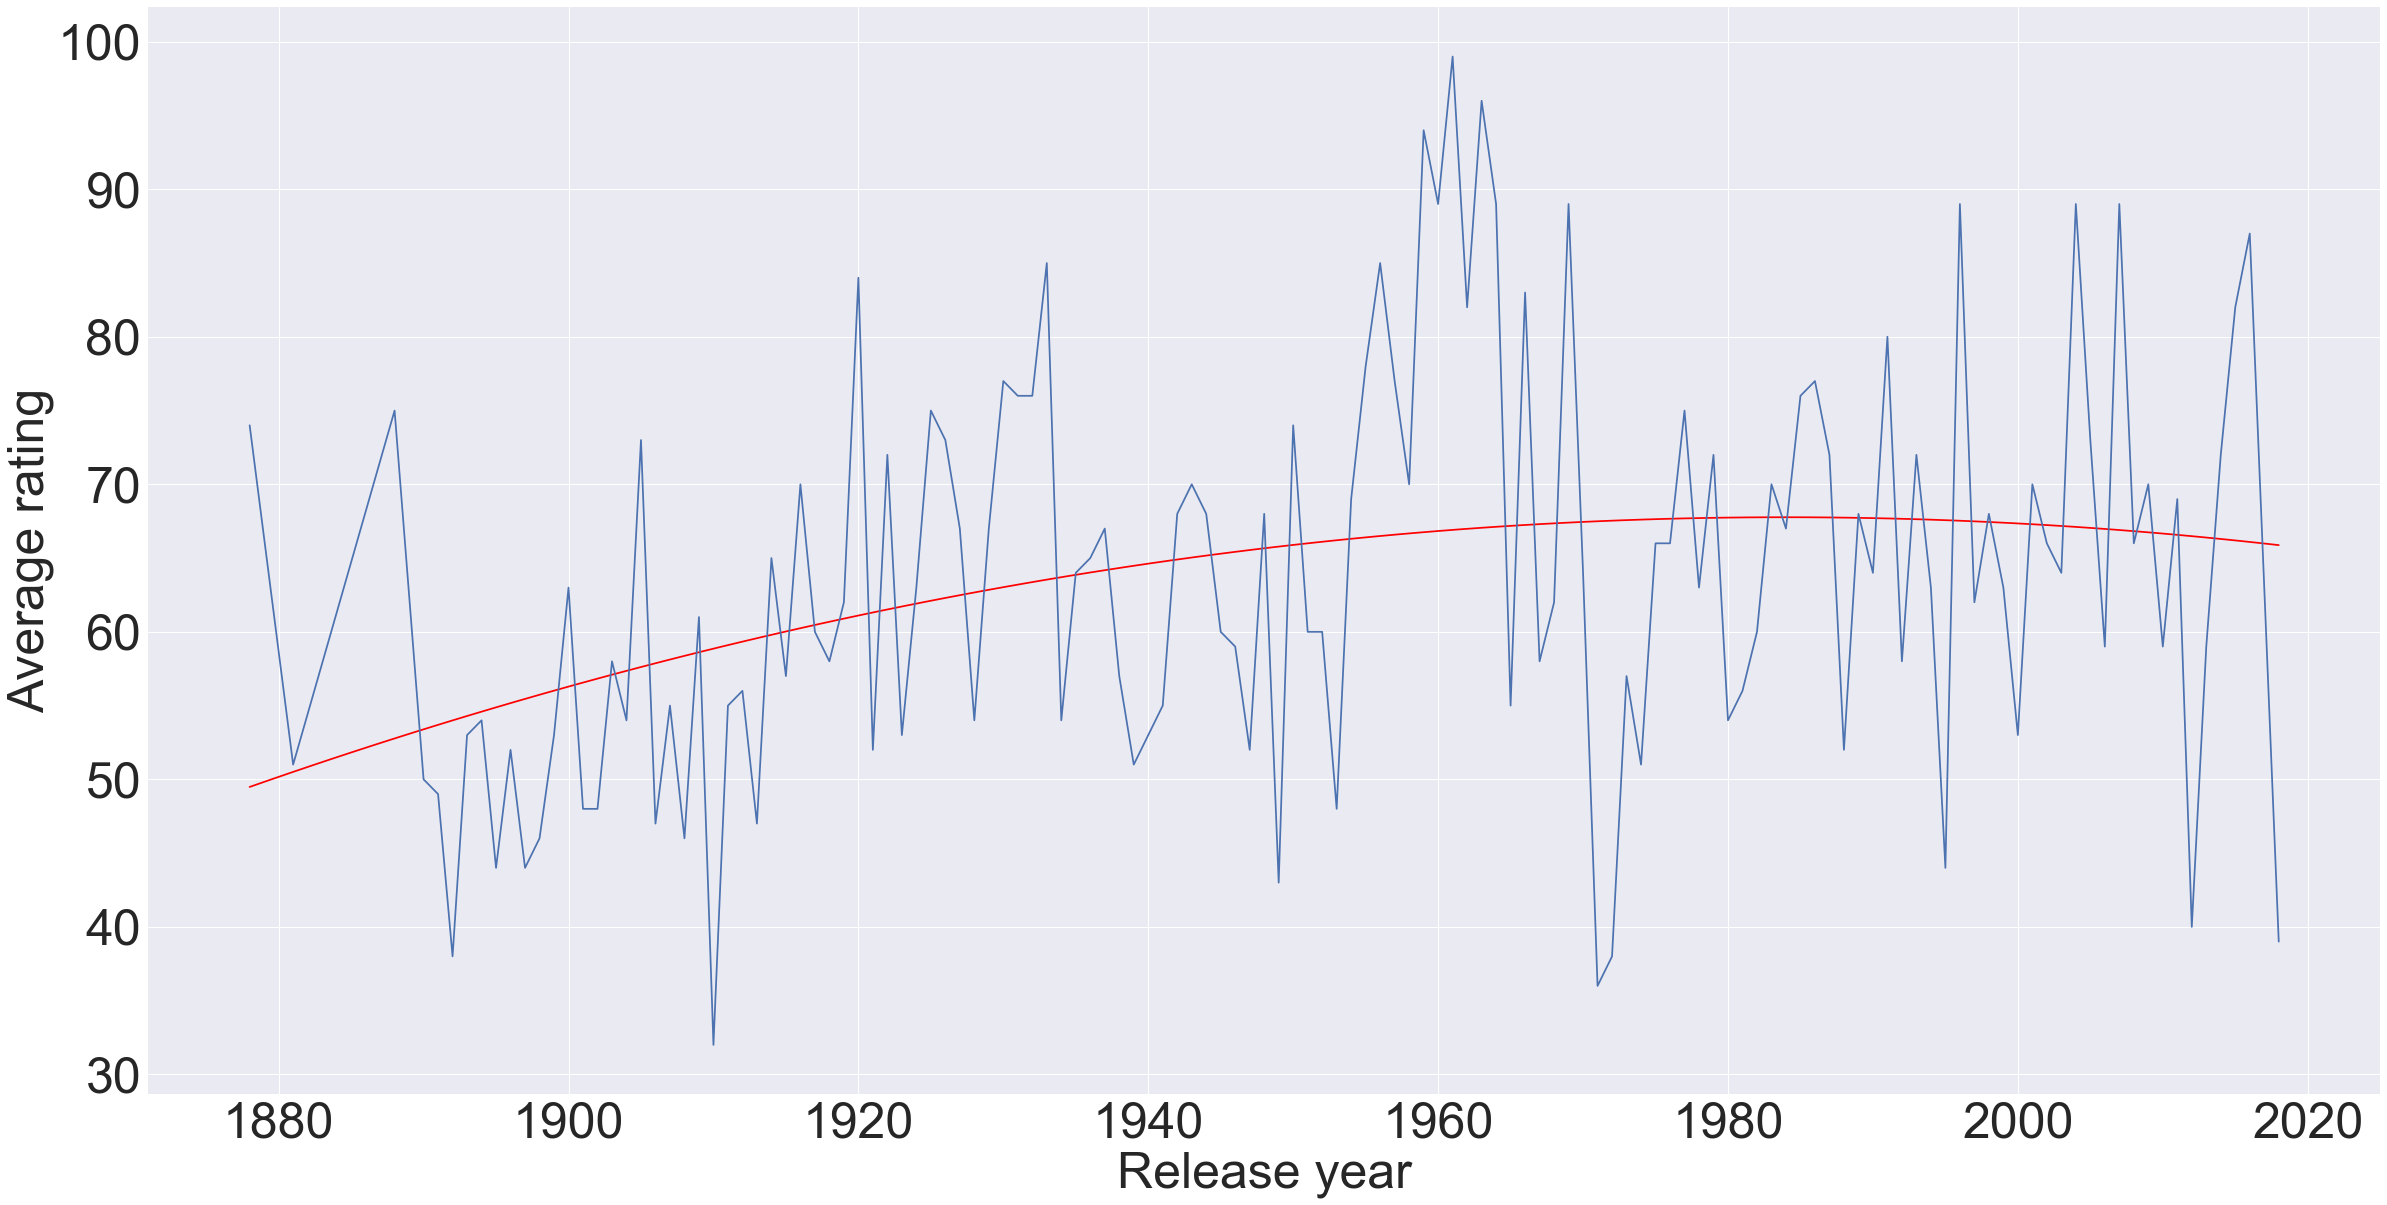

In [30]:
sorted_year_vote = sorted(year_dict_vote.items())
year, abs_vote = zip(*sorted_year_vote)
avg_vote = [y[0]/y[1] for y in abs_vote]

x_pred = np.linspace(year[0], year[-1], 100)
gp = GaussianProcess(theta0=1, thetaL=0.00001, thetaU=1000, nugget=0.000001)
gp.fit(np.atleast_2d(year).T, avg_vote)
y_pred = gp.predict(np.atleast_2d(x_pred).T)

plt.figure( figsize=(40, 20))
plt.xlabel('Release year',fontsize=50)
plt.ylabel('Average rating',fontsize=50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.plot(x_pred, y_pred, color='red')
plt.plot(year, avg_vote)
plt.show()

# Keywords list

In [31]:
keywords_dict={}
for index, row in test_data.iterrows():
    row_keywords=ast.literal_eval(row['keywords'])
    for keyword in row_keywords:
        if keyword['name'] not in keywords_dict:
            keywords_dict[keyword['name']]=0
        keywords_dict[keyword['name']]=keywords_dict[keyword['name']]+1       


In [32]:
sorted_k = sorted(keywords_dict.items(), key=operator.itemgetter(1),reverse=True)

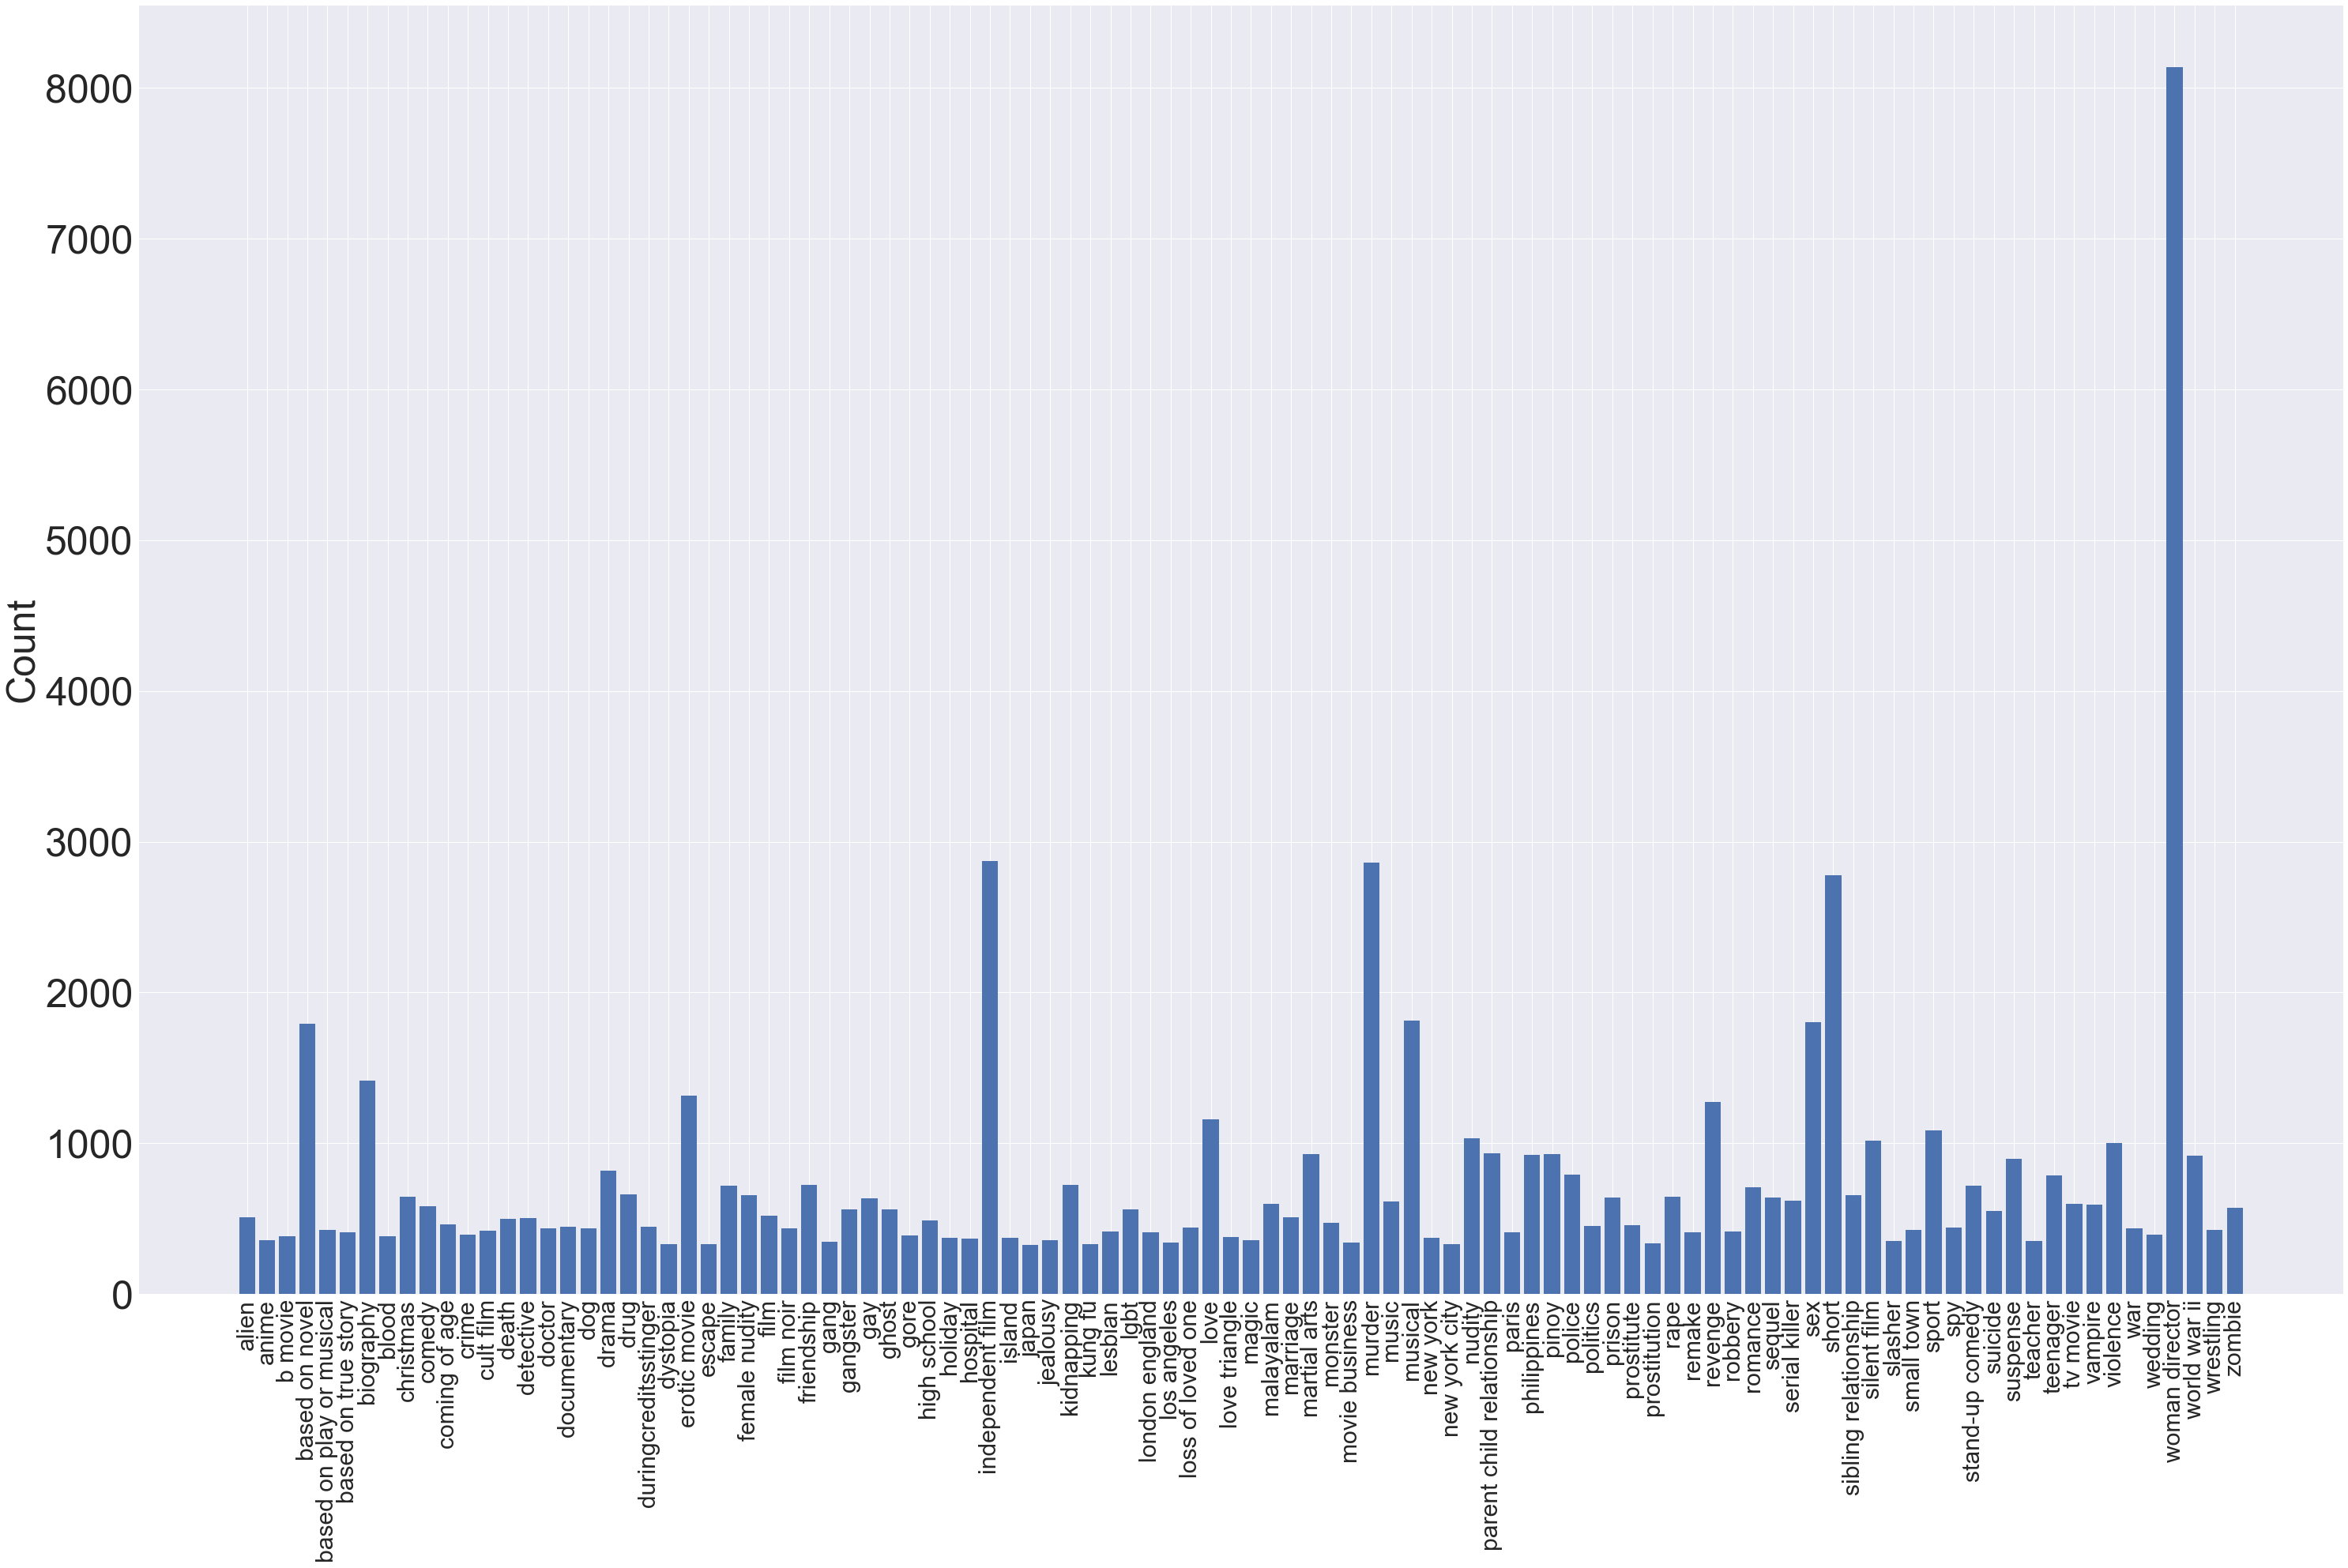

In [35]:
labels_k, data = zip(*sorted_k[:100])

plt.figure( figsize=(50, 30))
plt.bar(labels_k, data)
plt.ylabel('Count',fontsize=50)
plt.xticks(fontsize=30,rotation=90)
plt.yticks(fontsize=50)
plt.show()

In [7]:
x_keyword=[]
y_rating=[]

for index, row in test_data.iterrows():
    row_keywords=ast.literal_eval(row['keywords'])
    for keyword in row_keywords:
        if keyword['name'] not in labels_k:
            continue
        x_keyword.append(keyword['name'])
        y_rating.append(row['rating'])   

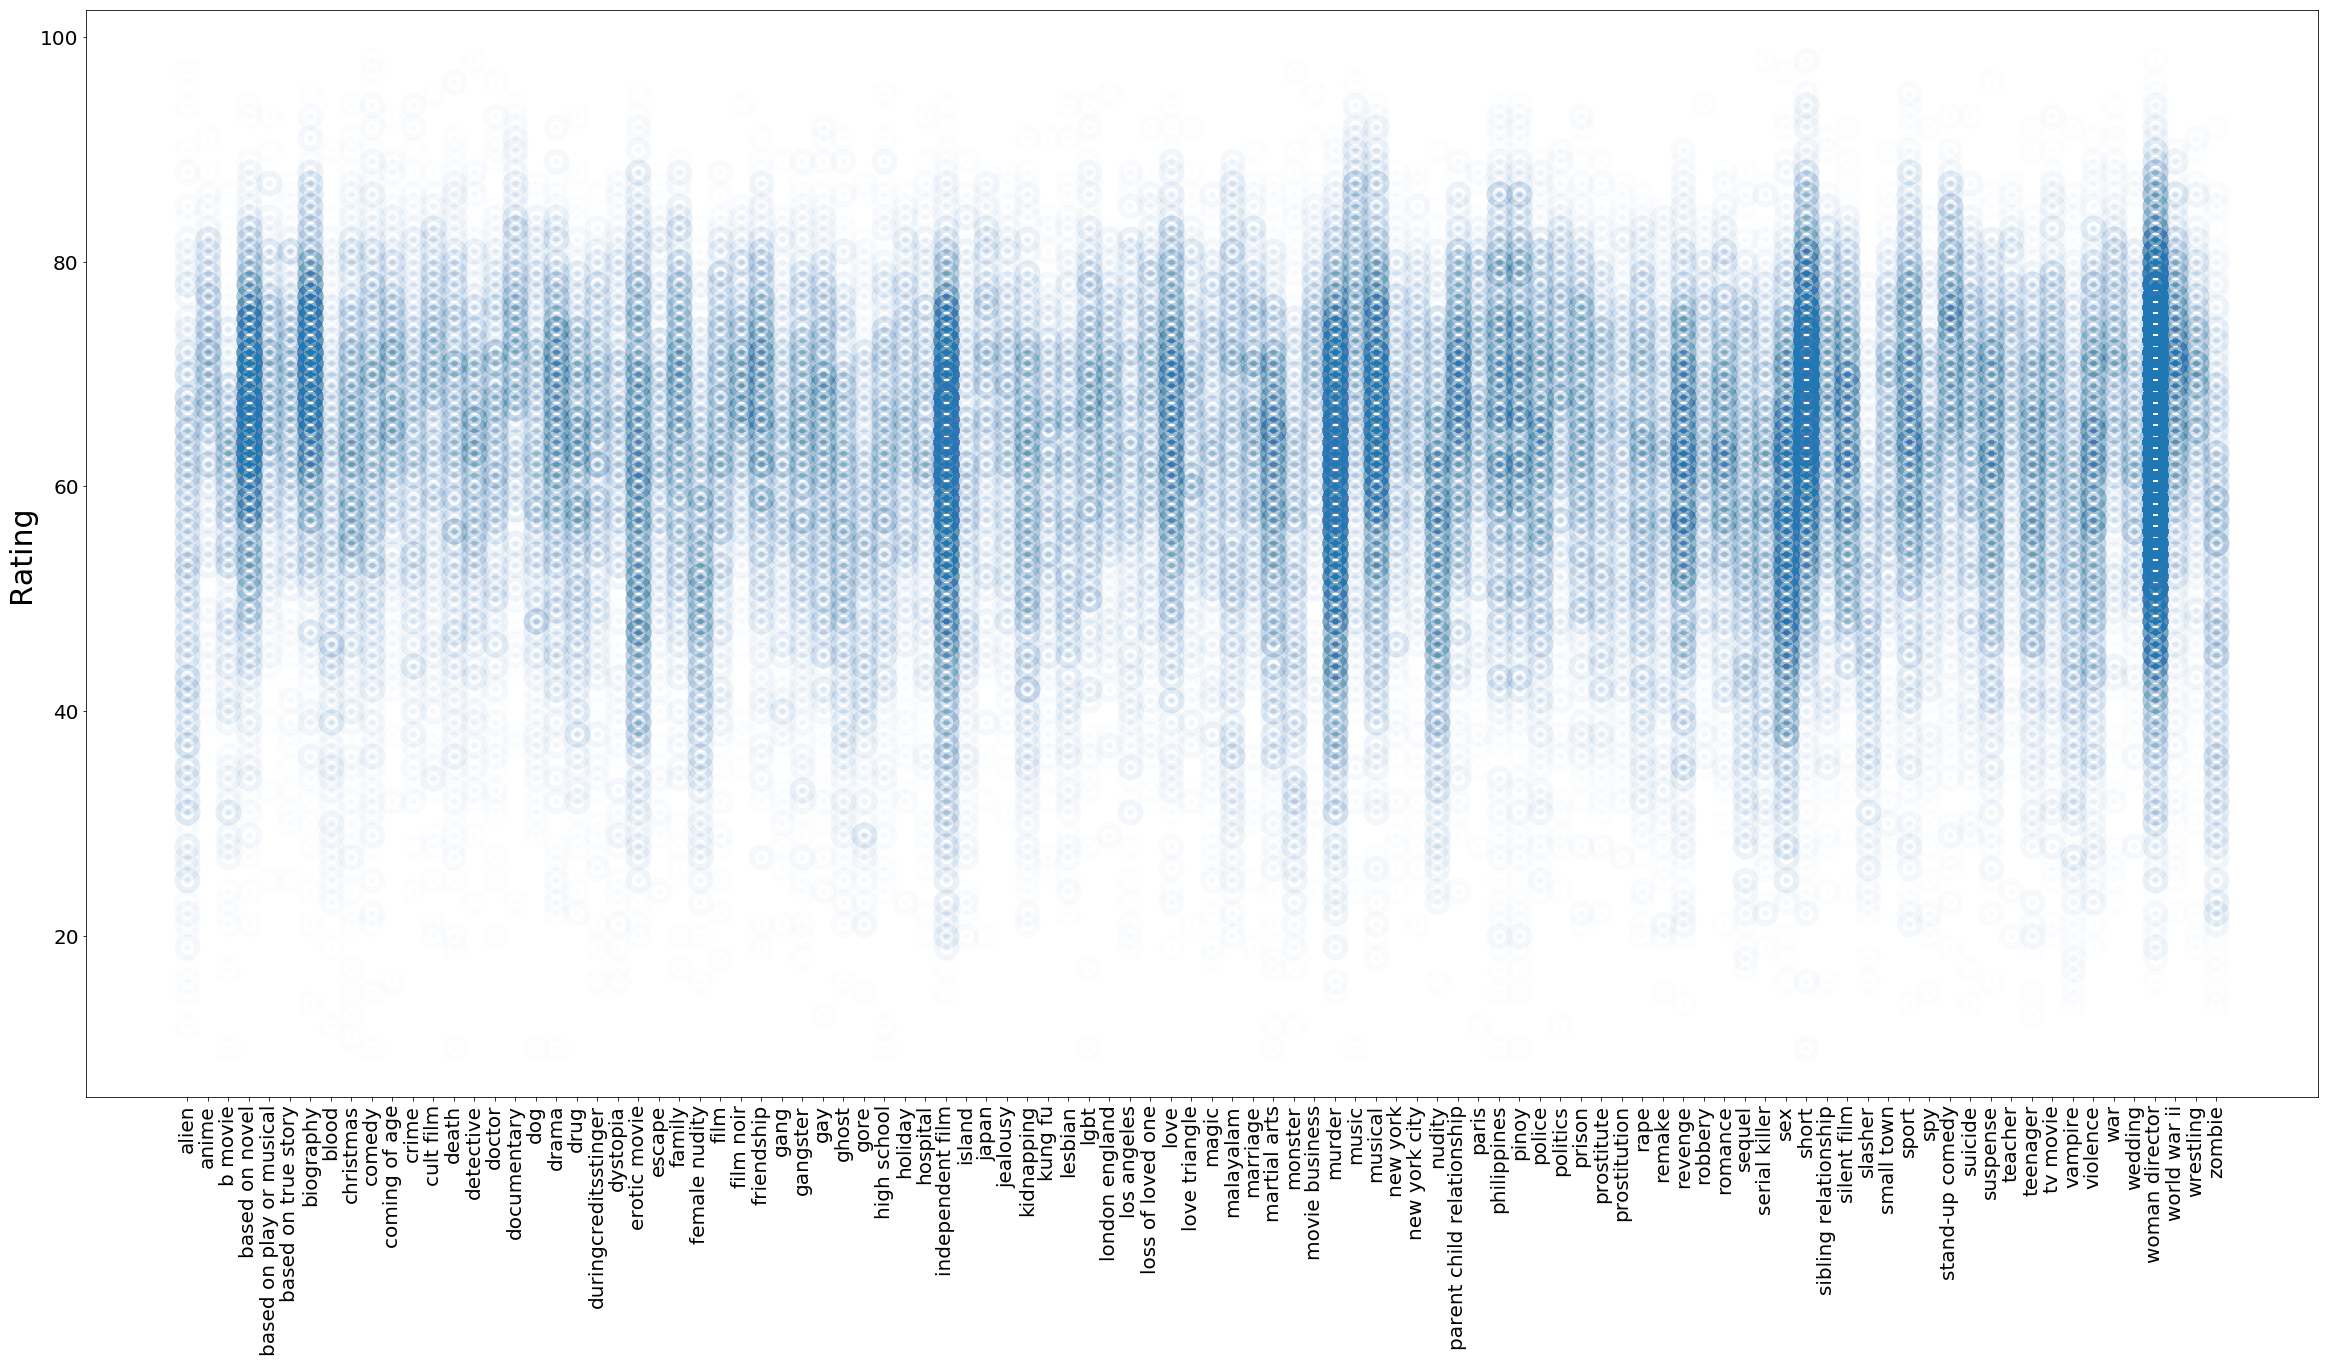

In [9]:
plt.figure( figsize=(40, 20))
plt.ylabel('Rating',fontsize=30)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.scatter(x_keyword, y_rating, alpha=0.01,linewidth=20)
plt.show()

In [24]:
key_dict={}
for index, row in test_data.iterrows():
    row_keywords=ast.literal_eval(row['keywords'])
    for keyword in row_keywords:
        if keyword['name'] not in labels_k:
            continue
        if keyword['name'] not in key_dict:
            key_dict[keyword['name']]=[0,0]
        key_dict[keyword['name']][1]=key_dict[keyword['name']][1]+1
        key_dict[keyword['name']][0]=key_dict[keyword['name']][0]+row['rating']

In [37]:
x_count=[]
y_avgrat=[]
z_label=[]
for key,val in key_dict.items():
    x_count.append(val[1])
    y_avgrat.append(val[0]/val[1])
    z_label.append(key)

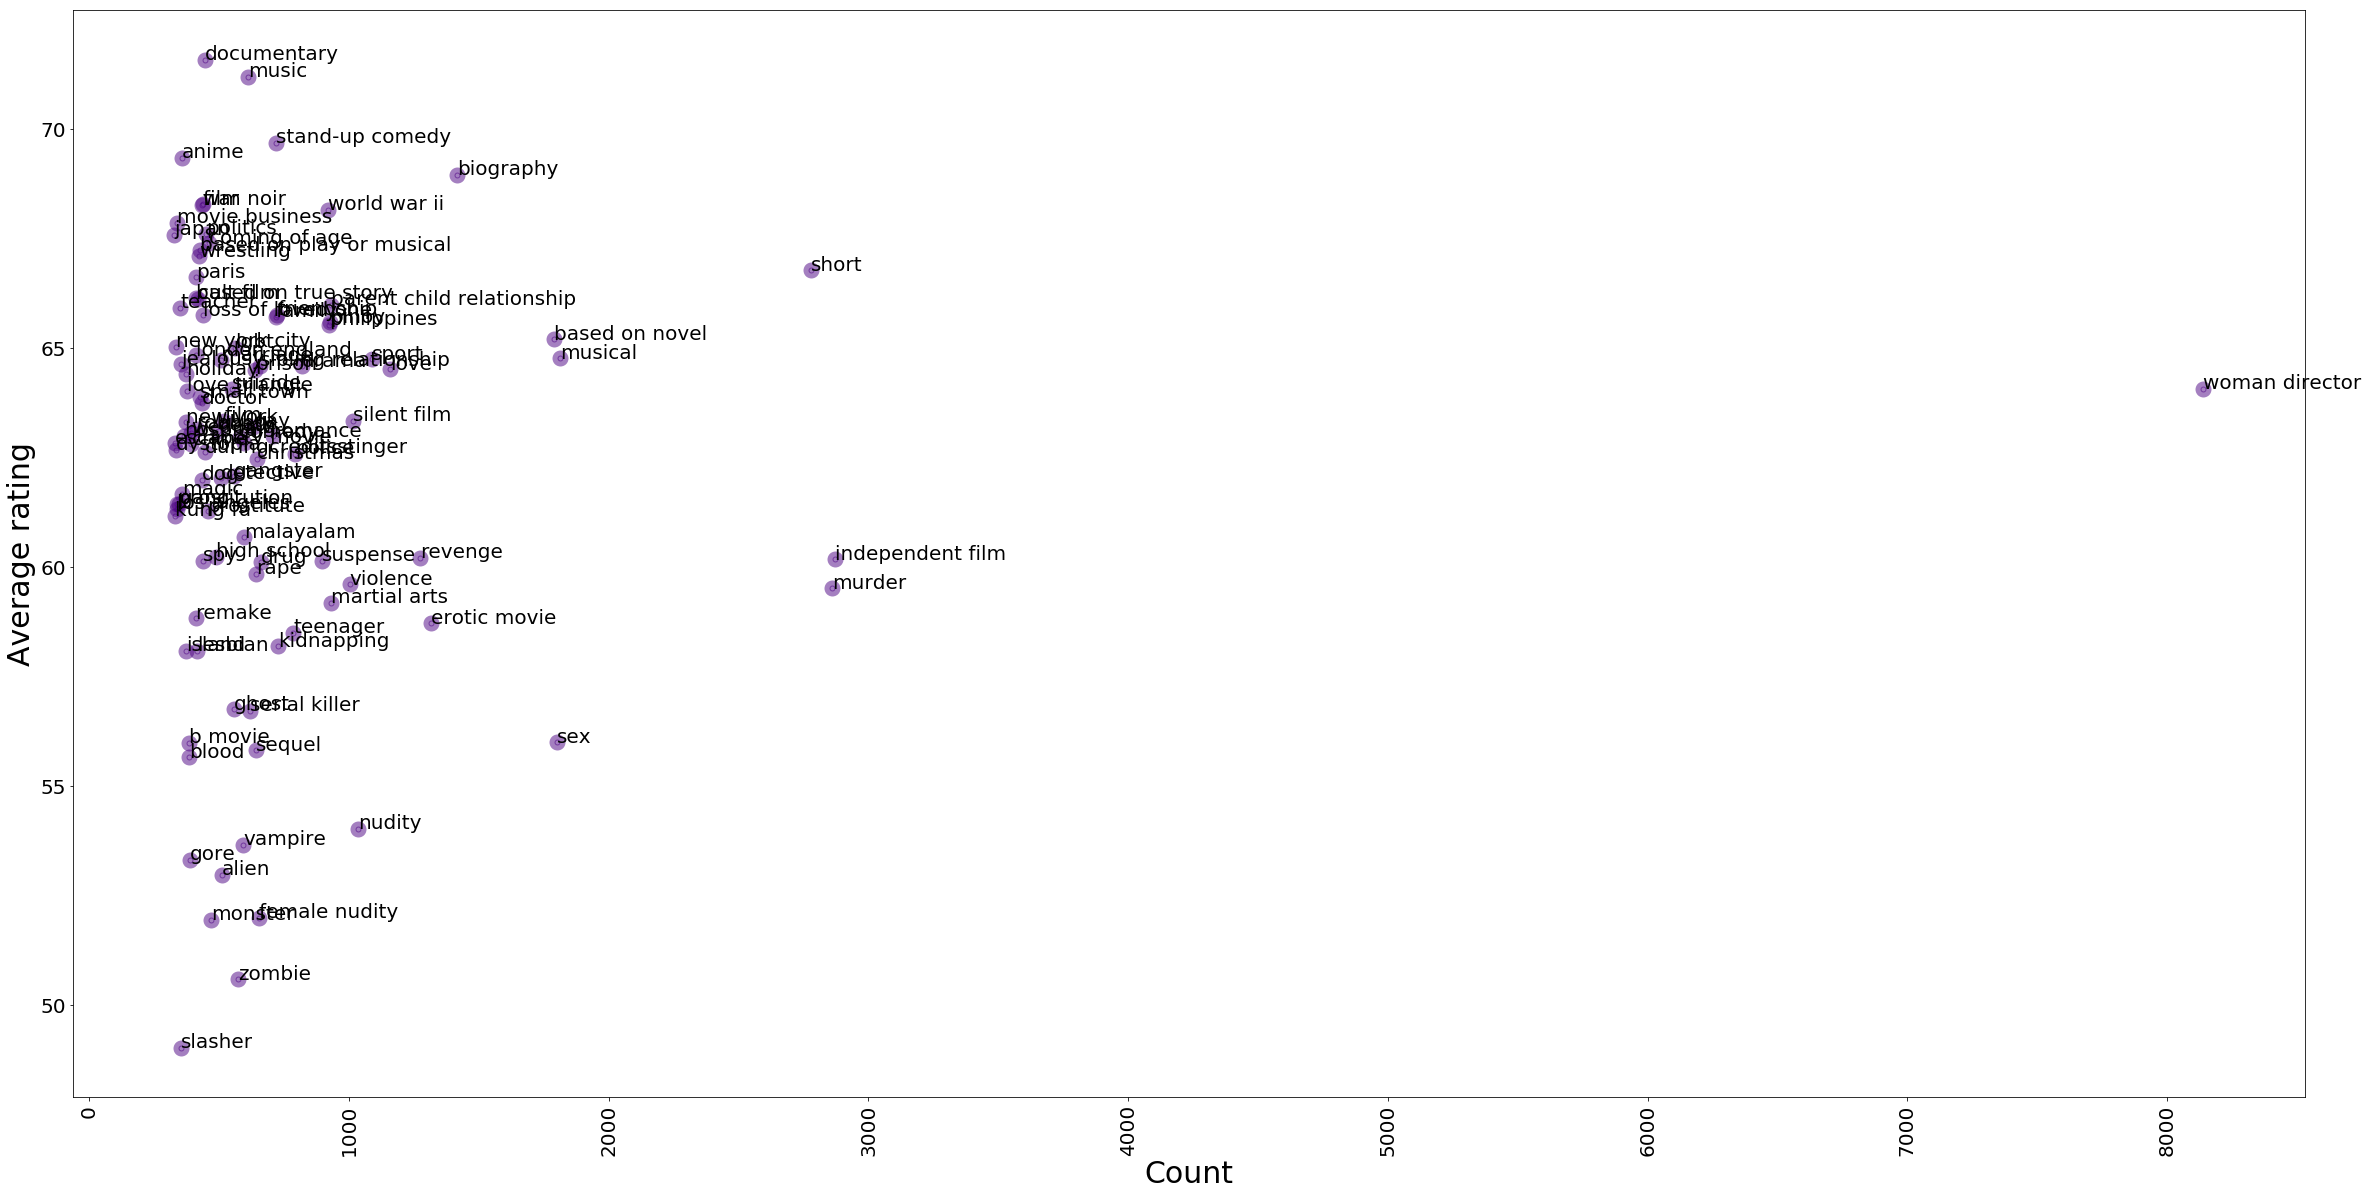

In [49]:
fig, ax = plt.subplots(figsize=(40, 20))

# plt.figure( figsize=(40, 20))
# plt.ylabel('Average rating',fontsize=30)
# plt.xlabel('Count',fontsize=30)
# plt.xticks(fontsize=20,rotation=90)
# plt.yticks(fontsize=20)
# plt.scatter(x_count, y_avgrat, alpha=0.5,linewidth=10,color='indigo')


ax.scatter(x_count, y_avgrat, alpha=0.5,linewidth=10,color='indigo')
plt.ylabel('Average rating',fontsize=30)
plt.xlabel('Count',fontsize=30)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
for i, txt in enumerate(z_label):
    ax.annotate(txt, (x_count[i],y_avgrat[i]),fontsize=20)

plt.show()

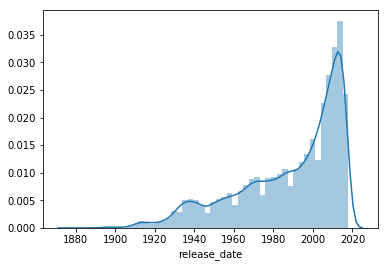

In [11]:
sns.distplot(corr_data["release_date"]);

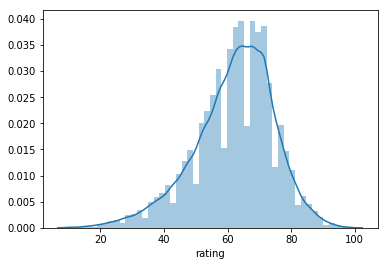

In [12]:
sns.distplot(corr_data["rating"]);

# Calculate scores 

In [17]:
import time
start_time = time.time()

keywords_value_dict={}
for index, row in test_data.iterrows():
    row_keywords=ast.literal_eval(row['keywords'])
    for keyword in row_keywords:
        if keyword['name'] not in keywords_value_dict:
            keywords_value_dict[keyword['name']]=[0,0]
        keywords_value_dict[keyword['name']][0]=keywords_value_dict[keyword['name']][0]+1       
        keywords_value_dict[keyword['name']][1]=keywords_value_dict[keyword['name']][1]+row['rating']  
        
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
keyword_scores=[]
for index, row in test_data.iterrows():
    summa=0
    count=0
    row_keywords=ast.literal_eval(row['keywords'])
    for keyword in row_keywords:
        summa=summa+keywords_value_dict[keyword['name']][1]/keywords_value_dict[keyword['name']][0]
        count=count+1
    if(count!=0):
        keyword_scores.append(summa/count)
    else:
        keyword_scores.append(0)
test_data['keyword_score']=keyword_scores
print("--- %s seconds ---" % (time.time() - start_time))

--- 21.149383783340454 seconds ---
--- 17.851742267608643 seconds ---


In [5]:
start_time = time.time()

cast_value_dict={}
for index, row in test_data.iterrows():
    row_cast=ast.literal_eval(row['cast'])
    for cast in row_cast:
        if cast['name'] not in cast_value_dict:
            cast_value_dict[cast['name']]=[0,0]
        cast_value_dict[cast['name']][0]=cast_value_dict[cast['name']][0]+1       
        cast_value_dict[cast['name']][1]=cast_value_dict[cast['name']][1]+row['rating']  
        
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
cast_scores=[]
for index, row in test_data.iterrows():
    summa=0
    count=0
    row_cast=ast.literal_eval(row['cast'])
    for cast in row_cast:
        summa=summa+cast_value_dict[cast['name']][1]/cast_value_dict[cast['name']][0]
        count=count+1
    if(count!=0):
        cast_scores.append(summa/count)
    else:
        cast_scores.append(0)
test_data['cast_score']=cast_scores
print("--- %s seconds ---" % (time.time() - start_time))

--- 62.34231209754944 seconds ---
--- 46.96127891540527 seconds ---


In [46]:
# sorted(cast_value_dict.items(), key=lambda x:x[1],reverse=True)[0:100]

In [45]:
# sorted(cast_value_dict.items(), key=lambda x:x[1][1]/x[1][0] and x[1][0]>10,reverse=True)[0:100]

In [18]:
start_time = time.time()

crew_value_dict={}
for index, row in test_data.iterrows():
    row_crew=ast.literal_eval(row['crew'])
    for crew in row_crew:
        if crew['name'] not in crew_value_dict:
            crew_value_dict[crew['name']]=[0,0]
        crew_value_dict[crew['name']][0]=crew_value_dict[crew['name']][0]+1       
        crew_value_dict[crew['name']][1]=crew_value_dict[crew['name']][1]+row['rating']  
        
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
crew_scores=[]
for index, row in test_data.iterrows():
    summa=0
    count=0
    row_crew=ast.literal_eval(row['crew'])
    for crew in row_crew:
        summa=summa+crew_value_dict[crew['name']][1]/crew_value_dict[crew['name']][0]
        count=count+1
    if(count!=0):
        crew_scores.append(summa/count)
    else:
        crew_scores.append(0)
test_data['crew_score']=crew_scores
print("--- %s seconds ---" % (time.time() - start_time))

--- 55.04040598869324 seconds ---
--- 43.73462772369385 seconds ---


# Select features

In [19]:
pred_data=test_data[['rating','rating_count','adult','runtime','release_date','budget_moviedb',
                     'revenue_moviedb','budget_imdb','revenue_imdb','revenue_USA','keyword_score','cast_score','crew_score']].copy()
pred_data['release_date']=pred_data['release_date'].str[:-6]
pred_data = pred_data[pd.notnull(pred_data['release_date'])]
pred_data['release_date']=(pred_data['release_date']).astype(int)


pred_data['revenue']=pred_data['revenue_moviedb']
pred_data['revenue']=pred_data['revenue'].replace(0, np.nan)
pred_data['revenue']=pred_data['revenue'].fillna(pred_data['revenue_imdb'])
pred_data['revenue']=pred_data['revenue'].fillna(pred_data['revenue_USA'])
pred_data['revenue']=pred_data['revenue'].fillna(0)

pred_data['budget']=pred_data['budget_moviedb']
pred_data['budget']=pred_data['budget'].replace(0, np.nan)
pred_data['budget']=pred_data['budget'].fillna(pred_data['budget_imdb'])
pred_data['budget']=pred_data['budget'].fillna(0)


pred_data = pred_data[pd.notnull(pred_data['runtime'])]
pred_data = pred_data.reset_index(drop=True)
pred_data=pred_data.drop(['revenue_moviedb','revenue_imdb','revenue_USA','budget_moviedb','budget_imdb'],axis=1)


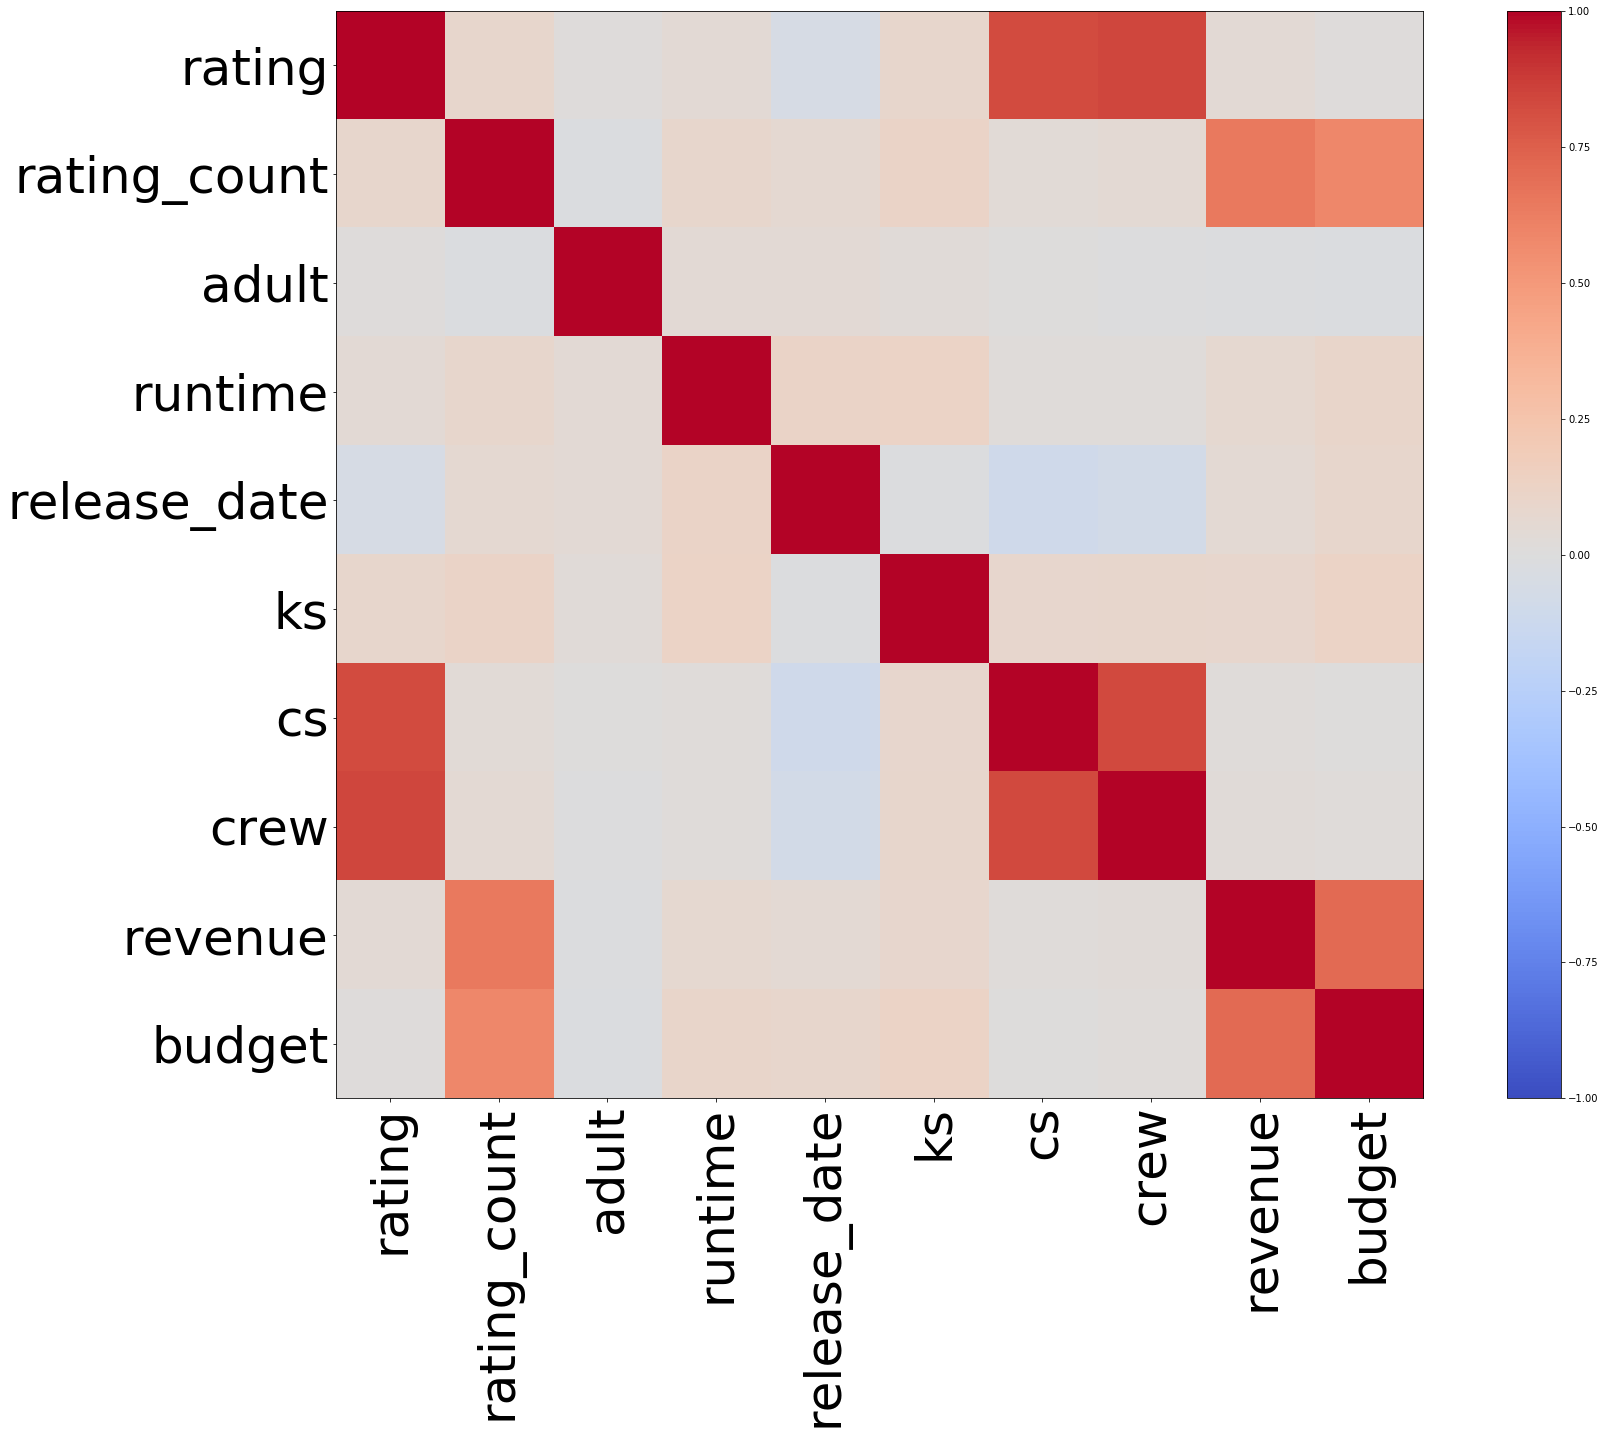

In [9]:
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(30)

image=ax.matshow(pred_data.corr(),interpolation='nearest', cmap=cm.coolwarm,vmin=-1, vmax=1)
colorbar=fig.colorbar(image)

labels=['rating','rating_count','adult','runtime','release_date','ks','cs',
        'crew','revenue','budget']

ax.set_xticklabels([''] + labels,fontsize=50)
ax.set_yticklabels([''] + labels,fontsize=50)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
od=plt.xticks(rotation='vertical')

# Normalize

In [20]:
from sklearn import preprocessing

numpy_arrays = pred_data.values 
headers=list(pred_data.columns.values)
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(numpy_arrays)
reg_data = pd.DataFrame(scaled)
reg_data.columns=headers

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.grid_search import GridSearchCV

x_val=[list(a) for a in zip(reg_data['runtime'],reg_data['release_date'],reg_data['adult']
                            ,reg_data['keyword_score'],reg_data['cast_score'],reg_data['crew_score'])]
rating=reg_data['rating']

train,test, rating_train, rating_test = train_test_split(x_val, rating, test_size=0.3, random_state=0)

In [12]:
wood = RandomForestRegressor(n_estimators=50,max_depth=10, random_state=0)
wood.fit(train, rating_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [13]:
rating_pred = wood.predict(test)

In [14]:
wood.score(test,rating_test)

0.7780495107399286

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(rating_test, rating_pred))
print(rms)

0.0659828609603058


In [ ]:
param_grid = { 
    'n_estimators': [10,20,30],
    'max_depth':[2,10,20,30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['mse', 'mae']
}

CV_rfc = GridSearchCV(estimator=wood, param_grid=param_grid, cv= 5)
CV_rfc.fit(test, rating_test)
print (CV_rfc.best_params_)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.grid_search import GridSearchCV

x_val=[list(a) for a in zip(reg_data['cast_score'],reg_data['crew_score'])]

rating=reg_data['rating']

train,test, rating_train, rating_test = train_test_split(x_val, rating, test_size=0.3, random_state=0)

In [22]:
wood = RandomForestRegressor(n_estimators=50,max_depth=10, random_state=0)
wood.fit(train, rating_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [23]:
rating_pred = wood.predict(test)

In [24]:
wood.score(test,rating_test)

0.7695564001129724

In [41]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.grid_search import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import tree

x_val=[list(a) for a in zip(reg_data['runtime'],reg_data['release_date'],reg_data['adult']
                            ,reg_data['keyword_score'],reg_data['cast_score'],reg_data['crew_score'])]
rating=reg_data['rating']

train,test, rating_train, rating_test = train_test_split(x_val, rating, test_size=0.3, random_state=0)

In [42]:
#wood = linear_model.LinearRegression()
#wood=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
wood=tree.DecisionTreeRegressor()
wood.fit(train, rating_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [43]:
rating_pred = wood.predict(test)

In [44]:
wood.score(test,rating_test)

0.5486138710190106